## Explore PFT calibration
#### GP emulators for PFT mean LAI

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os
import seaborn as sns
import gpflow
import tensorflow as tf

from esem.utils import get_random_params, get_uniform_params

import warnings
warnings.filterwarnings("ignore")

2023-08-25 13:45:45.050944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 13:45:45.221427: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-25 13:45:45.278431: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-25 13:45:45.971279: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ; sys.path.append("../../") 
from ppe_analysis.analysis import *
from emulation_pyfunctions import *
from pyfunctions import *

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='24:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(100)

# Setup your client
client = Client(cluster)

In [5]:
client.cluster

PBSCluster(a7d71d51, 'tcp://10.12.206.51:39654', workers=10, threads=10, memory=232.80 GiB)

### Load LHC CLM-PPE (PFT mean annual max LAI)

In [6]:
# CLM-PPE
dvs=['TLAI']
htape='h1'
yr0=2003
yr1=2014
ds=get_exp('transient',dvs=dvs,tape=htape,yy=(yr0,yr1))

In [7]:
t=slice(str(yr0),str(yr1))
da=ds.TLAI.sel(time=t)
la=xr.open_dataset('landarea_transient.nc').landarea_pft.sel(time=t)
amax_lai=amax(da).mean(dim='year').compute()
PPE_lai = pmean(amax_lai,la).mean(dim='time').compute()

In [8]:
#get the pft names
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pfts=[str(p)[2:-1].strip() for p in pfts.values][0:17]

In [9]:
# load parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
lhc_params = df.drop(columns='member')
num_params = len(lhc_params.columns)

In [10]:
u_params     = ['FUN_fracfixers','KCN','a_fix','crit_dayl','d_max','fff','fstor2tran','grperc',
                'jmaxb0','jmaxb1','kcha','lmrha','lmrhd','nstem','q10_mr','soilpsi_off','sucsat_sf',
                'tpu25ratio','tpuse_sf','wc2wjb0']
pft_params   = ['froot_leaf','kmax','krmax','leaf_long','leafcn','lmr_intercept_atkin',
                'medlynslope','medlynintercept','psi50','slatop','stem_leaf','theta_cj']

In [68]:
# reorder ppe_params 
ppe_params = pd.concat([lhc_params[u_params], lhc_params[pft_params]],axis=1)
ppe_params.to_csv('ppe_params_8-25.csv', sep=',')

### Load Observational Target data

In [62]:
#calculate SP LAI, by pft
dsp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
dsp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
sg=xr.open_dataset('../clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
la=sg.landfrac*sg.area

lai_sp=amax(dsp.TLAI).sel(year=2000)
w=dsp.pfts1d_wtgcell
laig=pftgrid(lai_sp,dsp)
wg=pftgrid(w,dsp)
cf=1/(wg*la).sum(dim=['lat','lon'])
laisp=cf*(laig*wg*la).sum(dim=['lat','lon']).sel(pft=range(0,16)).compute()

### Train PFT emulators

In [13]:
# Define kernels
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

# select the kernal to use
kernel = kernel_linear + kernel_matern32 + kernel_RBF

2023-08-25 13:48:27.197454: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-25 13:48:27.197500: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc50): /proc/driver/nvidia/version does not exist
2023-08-25 13:48:27.208461: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: ./models/needleleaf_evergreen_temperate_tree/assets


INFO:tensorflow:Assets written to: ./models/needleleaf_evergreen_temperate_tree/assets


INFO:tensorflow:Assets written to: ./models/needleleaf_evergreen_boreal_tree/assets


INFO:tensorflow:Assets written to: ./models/needleleaf_evergreen_boreal_tree/assets


INFO:tensorflow:Assets written to: ./models/needleleaf_deciduous_boreal_tree/assets


INFO:tensorflow:Assets written to: ./models/needleleaf_deciduous_boreal_tree/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_evergreen_tropical_tree/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_evergreen_tropical_tree/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_evergreen_temperate_tree/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_evergreen_temperate_tree/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_tropical_tree/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_tropical_tree/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_temperate_tree/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_temperate_tree/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_boreal_tree/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_boreal_tree/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_evergreen_shrub/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_evergreen_shrub/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_temperate_shrub/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_temperate_shrub/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_boreal_shrub/assets


INFO:tensorflow:Assets written to: ./models/broadleaf_deciduous_boreal_shrub/assets


INFO:tensorflow:Assets written to: ./models/c3_arctic_grass/assets


INFO:tensorflow:Assets written to: ./models/c3_arctic_grass/assets


INFO:tensorflow:Assets written to: ./models/c3_non-arctic_grass/assets


INFO:tensorflow:Assets written to: ./models/c3_non-arctic_grass/assets


INFO:tensorflow:Assets written to: ./models/c4_grass/assets


INFO:tensorflow:Assets written to: ./models/c4_grass/assets


INFO:tensorflow:Assets written to: ./models/c3_crop/assets


INFO:tensorflow:Assets written to: ./models/c3_crop/assets


INFO:tensorflow:Assets written to: ./models/c3_irrigated/assets


INFO:tensorflow:Assets written to: ./models/c3_irrigated/assets


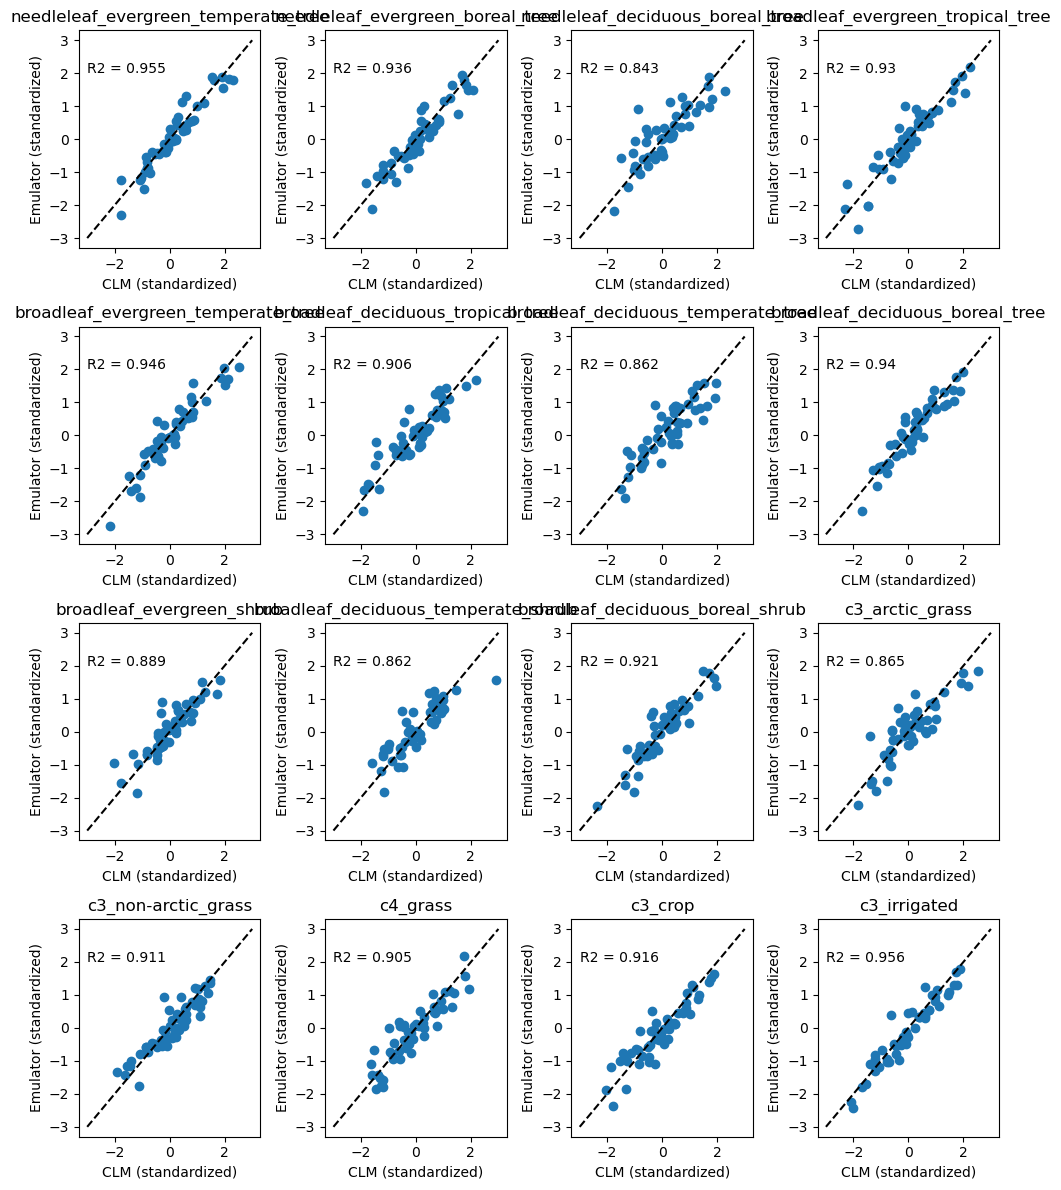

In [51]:
# train emulators (using GPFlow)

plt.figure(figsize=[10,12])
plt.rcParams.update({'font.size': 10})

PFT_emulator_dict = {}
keys = pfts

for i in range(1,17):

    y_data = PPE_lai.sel(pft=i)
    
    ax = plt.subplot(4,4,i)
    savedir = str('./models/'+keys[i])

    emulator = trainGP_GPFlow(y_data[1:],ppe_params,50,ax,kernel)
    
    #PFT_emulator_dict[keys[i]] = emulator
    
    emulator.compiled_predict_y = tf.function(
        lambda xnew: emulator.predict_y(xnew, full_cov=False),
        input_signature=[tf.TensorSpec(shape=[None, nparams], dtype=tf.float64)],
    )
    tf.saved_model.save(emulator, savedir)
    
    ax.set_title(pfts[i])

plt.tight_layout()
plt.savefig('./figs/PFT_LAImax_emulator_validation_GPFlow.png',dpi = 100)

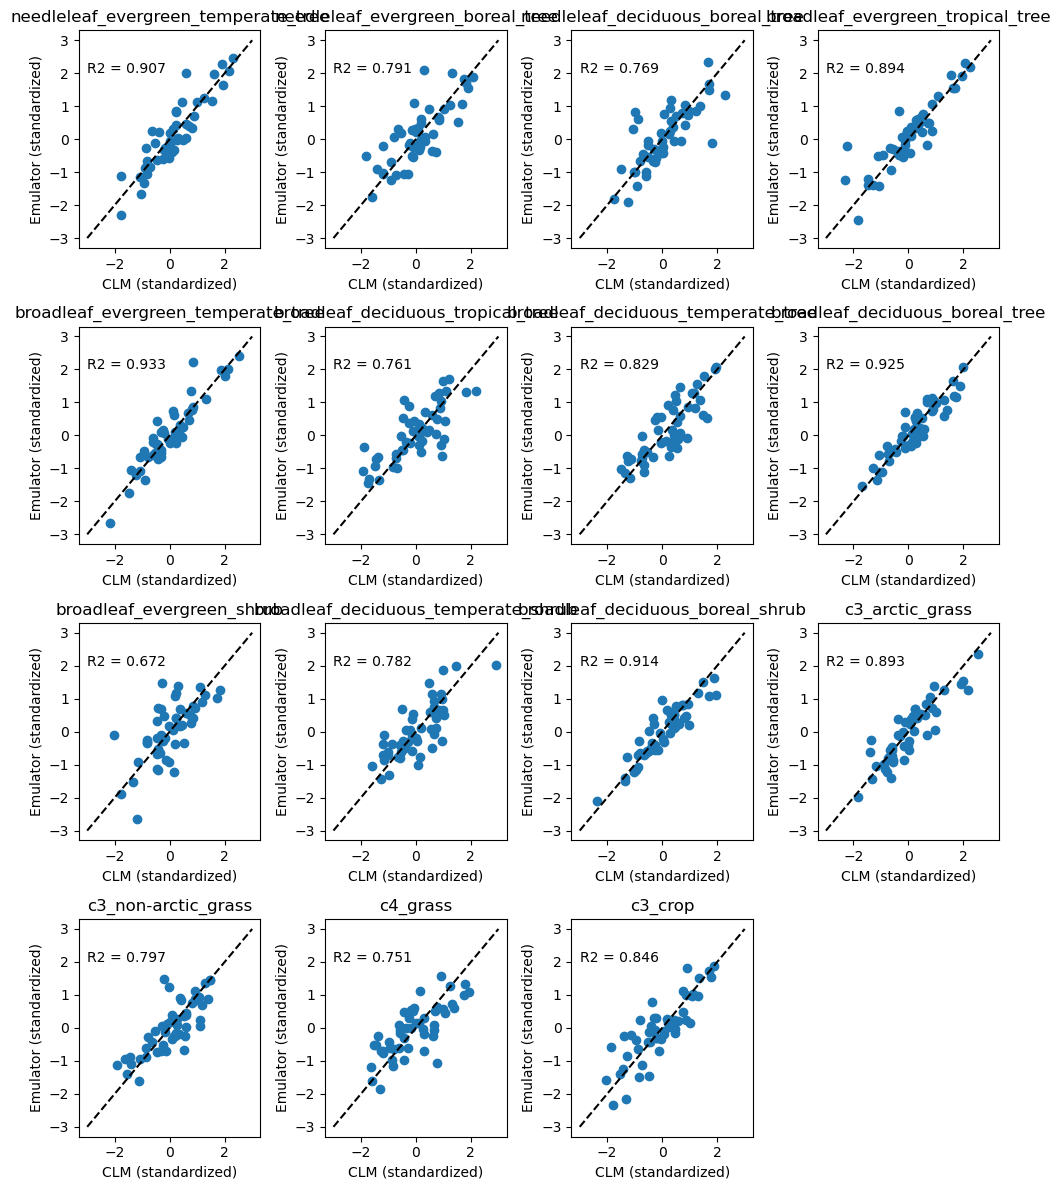

In [31]:
# ESEM train emulators and save in a dictionary 
plt.figure(figsize=[10,12])
plt.rcParams.update({'font.size': 10})

PFT_emulator_dict = {}
keys = pfts

for i in range(1,16):

    y_data = PPE_lai.sel(pft=i)
    
    ax = plt.subplot(4,4,i)

    emulator = trainGP_ESEm(y_data[1:],ppe_params,50,ax)
    
    PFT_emulator_dict[keys[i]] = emulator
    
    ax.set_title(pfts[i])

plt.tight_layout()
#plt.savefig('./figs/PFT_LAImax_emulator_validation.png',dpi = 100)

### Sample & Predict

In [126]:
#randomly sample universal parameters
np.random.seed(444)
n_usamp = 1000
u_sample = get_random_params(len(u_params), n_usamp)
np.savetxt("/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/universal_sample_8-25.txt", u_sample,delimiter=',')

In [127]:
# randomly sample PFT parameters
np.random.seed(22)
n_psamp = 100
pft_sample = get_random_params(len(pft_params), n_psamp)
np.savetxt("/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/pft_sample_8-25.txt", pft_sample,delimiter=',')

#uniform_sample = np.arange(0,1.0,0.025)
#n_psamp = len(uniform_sample)
#pft_sample = np.reshape(uniform_sample,(40,1))

In [128]:
n_pfts = 17
n_batch = 10
batch_size = np.int(n_usamp/n_batch)

# allocate output array
PFT_pred= np.empty([n_usamp,n_psamp,n_pfts])

In [129]:
batch_size

100

In [130]:
%%time

#loop through batches
st = 0
for i in range(n_batch):
    en = np.int(st+batch_size)
    print(en)
    
    tmp_samp = np.concatenate((np.repeat(u_sample[st:en,:],n_psamp,axis=0),np.tile(pft_sample,(batch_size,1))),axis=1)
    for j,p in enumerate(pfts[1:15]):
        loaded_emulator = tf.saved_model.load('./models/'+p)
        y_pred_std, _ = loaded_emulator.compiled_predict_y(tmp_samp) 
        y_pred = unstandardize(np.array(y_pred_std).reshape(1,-1),PPE_lai.sel(pft=j+1))
        PFT_pred[st:en,:,j+1] = np.reshape(y_pred,(batch_size,n_psamp))
    
    st = st+batch_size

100
200
300
400
500
600
700
800
900
1000
CPU times: user 1min 38s, sys: 1.04 s, total: 1min 39s
Wall time: 1min 47s


In [131]:
np.save('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/PFT_pred_8-25.npy',PFT_pred)

### Calculate metrics

In [133]:
laisp

<xarray.DataArray (pft: 16)>
array([       nan, 3.53179783, 2.91895973, 3.11051743, 4.93175992,
       3.59305257, 2.76815674, 3.30504625, 3.17454784, 0.53734455,
       0.54247099, 1.17644415, 1.00819218, 1.27039161, 1.52417235,
       2.19848416])
Coordinates:
  * pft      (pft) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 11.0 12.0 13.0 14.0 15.0

In [132]:
np.shape(PFT_pred)

(1000, 100, 17)

In [134]:
# Calculate the fractional bias 
fbias = np.empty(np.shape(PFT_pred[:,:,:16]))
tmp = np.tile(laisp,(n_psamp,1))
for i in range(n_usamp):
    var = PFT_pred[i,:,:16]
    fbias[i,:,:] = (var-tmp)/tmp

In [135]:
np.save('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/fractional_bias_8-25.npy',fbias)

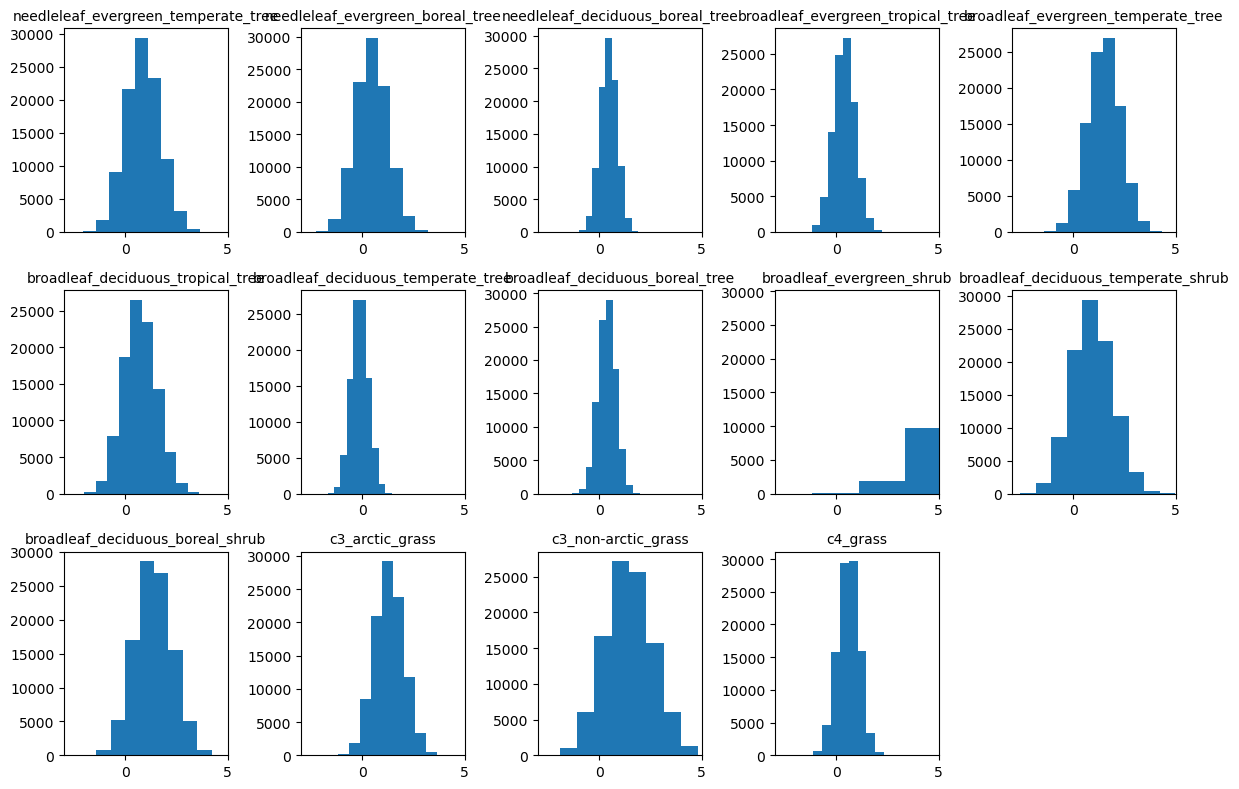

In [136]:
# plot fractional bias 
plt.figure(figsize=[12,8])
for i in range(1,15):
    plt.subplot(3,5,i)
    plt.hist(fbias[:,:,i].flatten())
    plt.title(pfts[i],fontsize=10)
    plt.xlim([-3,5])
    #plt.ylim([0,4000000])
    
plt.tight_layout()
plt.savefig('./figs/fbias_hist_10pft_8-25.png',dpi=100)

In [ ]:
### Drop the rest from here down

In [ ]:
# load LAI predicted
PFT_pred = np.load('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/PFT_pred_8-15.npy')
# load fbias
fbias = np.load('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/fractional_bias_8-15.npy')

In [32]:
# which universal sets have at least one member within uncertainty bounds for all PFTs?
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]
#pft_oerror = [.5,.3,.3,.3,.7,.3,.4,.3,.3,.6,.5,.3,.3] # set PFT specific error
pft_oerror = np.tile(0.01,len(pft_ids))

out = []
for i in range(n_usamp):
    passing_sets = np.transpose(np.abs(fbias[i,:,pft_ids]))<np.repeat([pft_oerror],n_psamp,axis=0)
    out.append(np.all(passing_sets.sum(axis=0)))

#number of passing universal sets 
np.array(out).sum()

1650

In [33]:
Usample_ix = np.where(out)
Usets = u_sample[out,:]

In [34]:
np.shape(Usets)

(1650, 20)

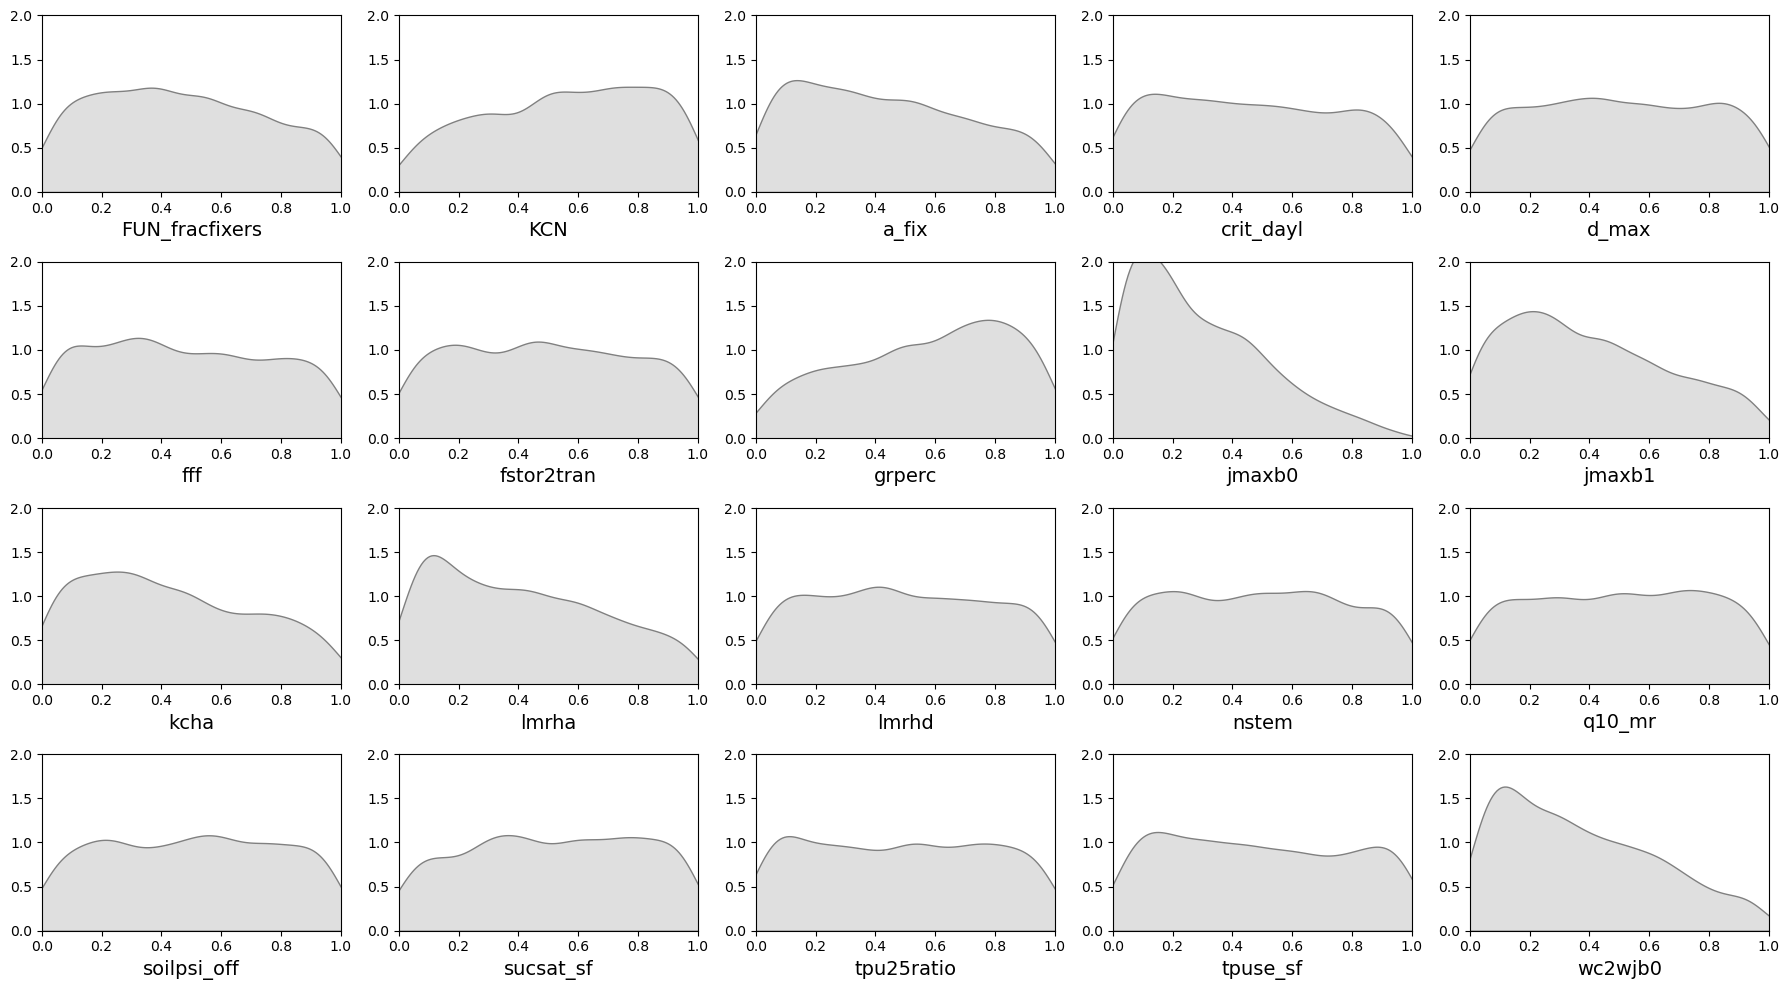

In [70]:
# plot distribution of universal parameter sets
df_Usets=pd.DataFrame(Usets,columns=ppe_params.columns[:len(u_params)])
plt.figure(figsize=[18,10])
for p in range(len(u_params)):
    plt.subplot(4,5,p+1)
    pname = df_Usets.columns[p]
    sns.distplot(df_Usets[pname], hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 1, "color":"grey"},
                label='')
    plt.xlim([0,1])
    plt.ylabel('')
    plt.xlabel(pname,fontsize=14)
    plt.ylim([0,2])
    #plt.legend()
plt.tight_layout()
plt.savefig('./figs/Usets_dist_SPtarget.png')

In [35]:
fbias_usets = fbias[out,:,:]

n_usets = np.shape(Usets)[0]
PFTsample_ix = np.empty((n_usets,n_psamp,16))
pft_param_values = np.empty((n_usets,n_psamp,np.shape(pft_sample)[1],16))

for i in range(n_usets):
    for j,p in enumerate(pft_ids):
        tmp = np.abs(fbias_usets[i,:,p])<0.01
        #tmp = np.abs(fbias_usets[i,:,p])<pft_oerror[p]
        PFTsample_ix[i,:,p] = tmp
        pft_param_values[i,0:len(pft_sample[tmp,:]),:,p] = pft_sample[tmp,:]

pft_param_values[pft_param_values==0] = np.nan

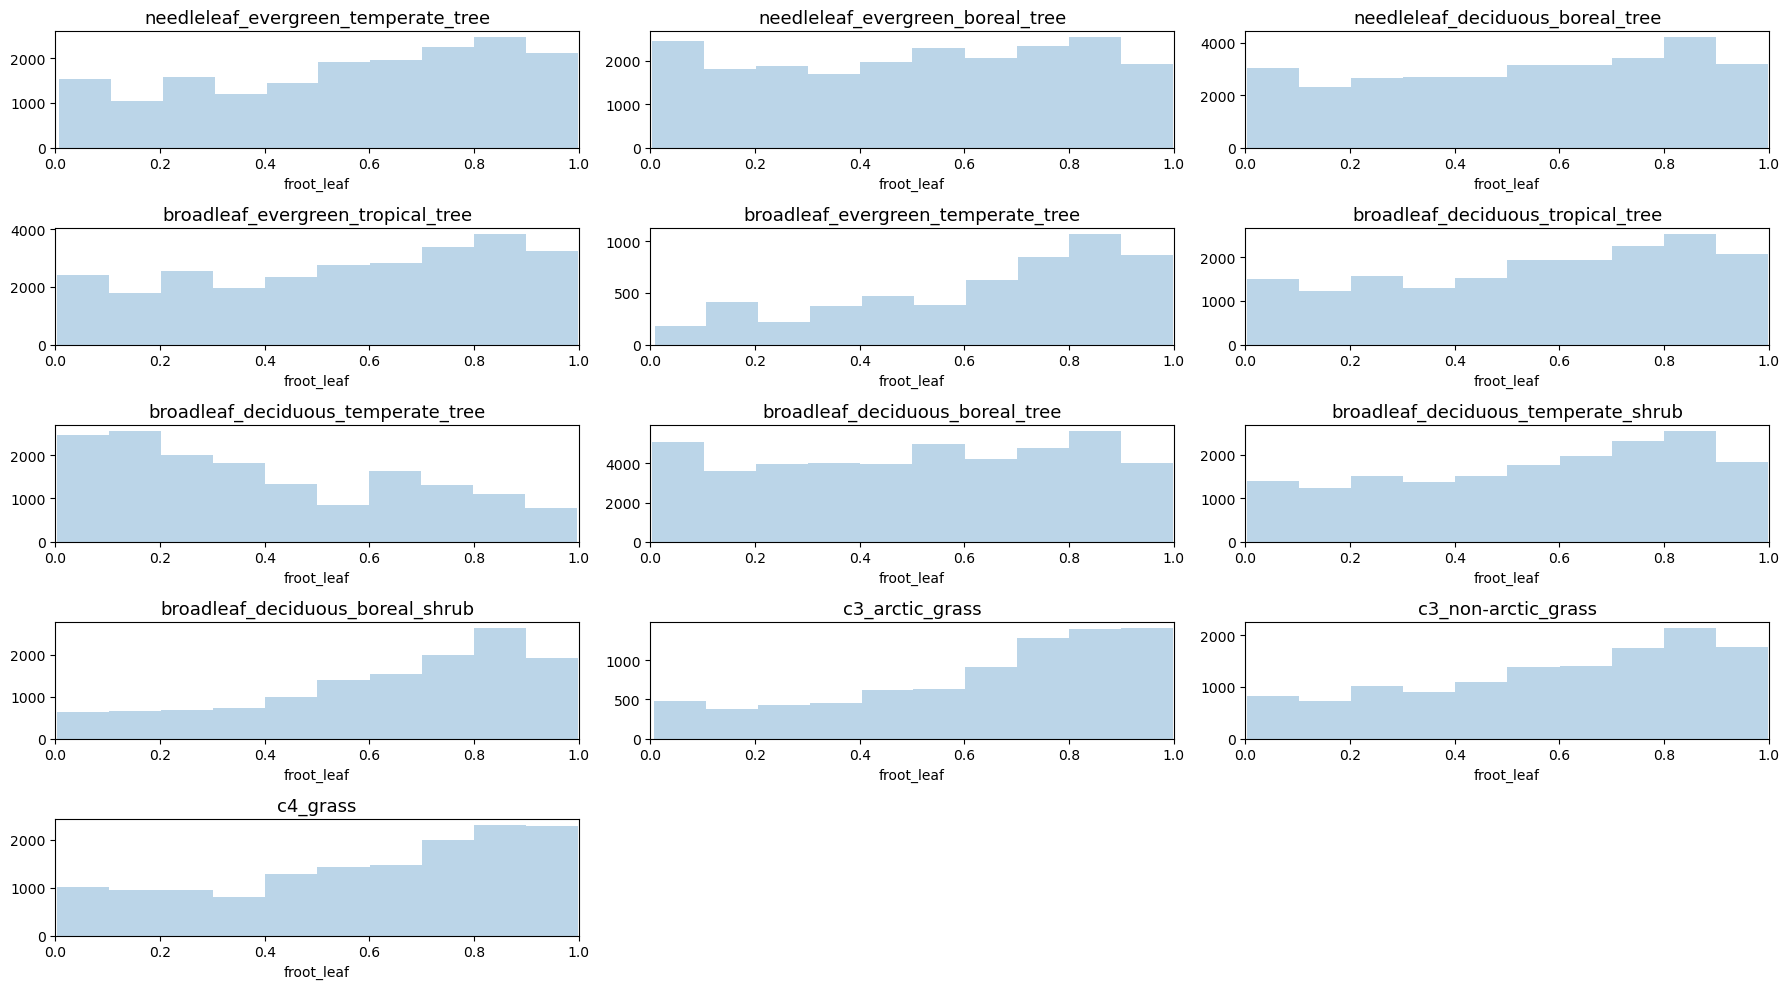

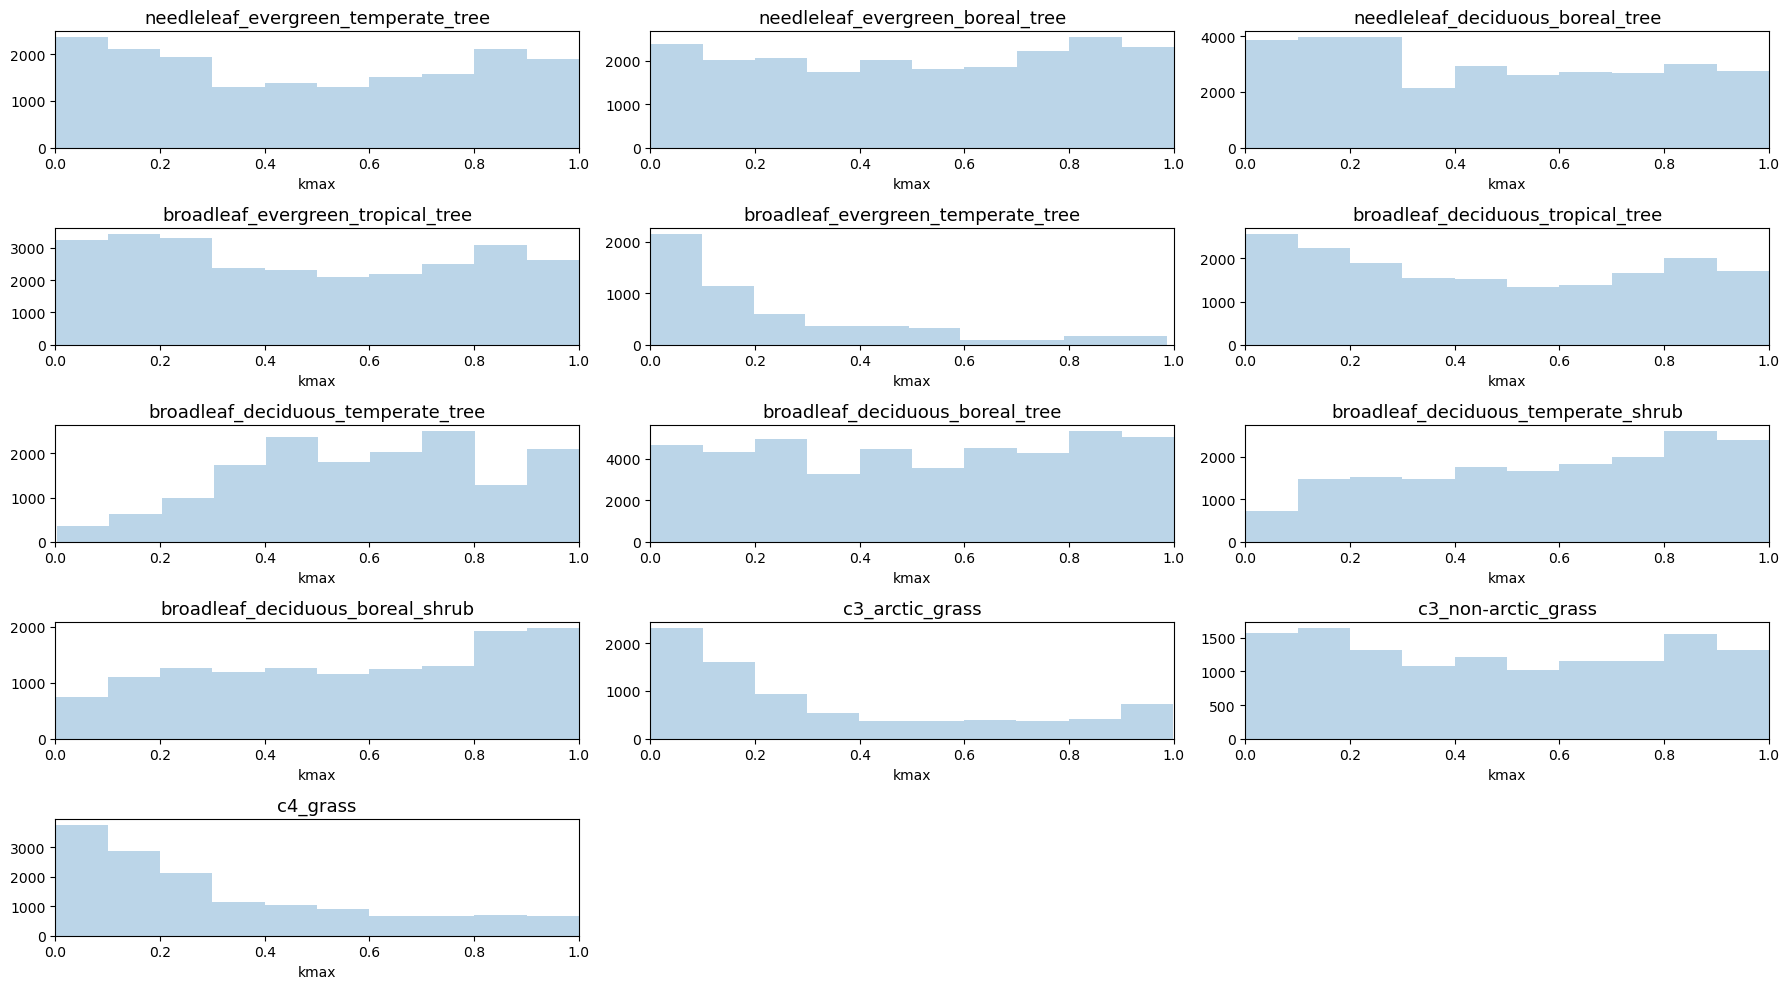

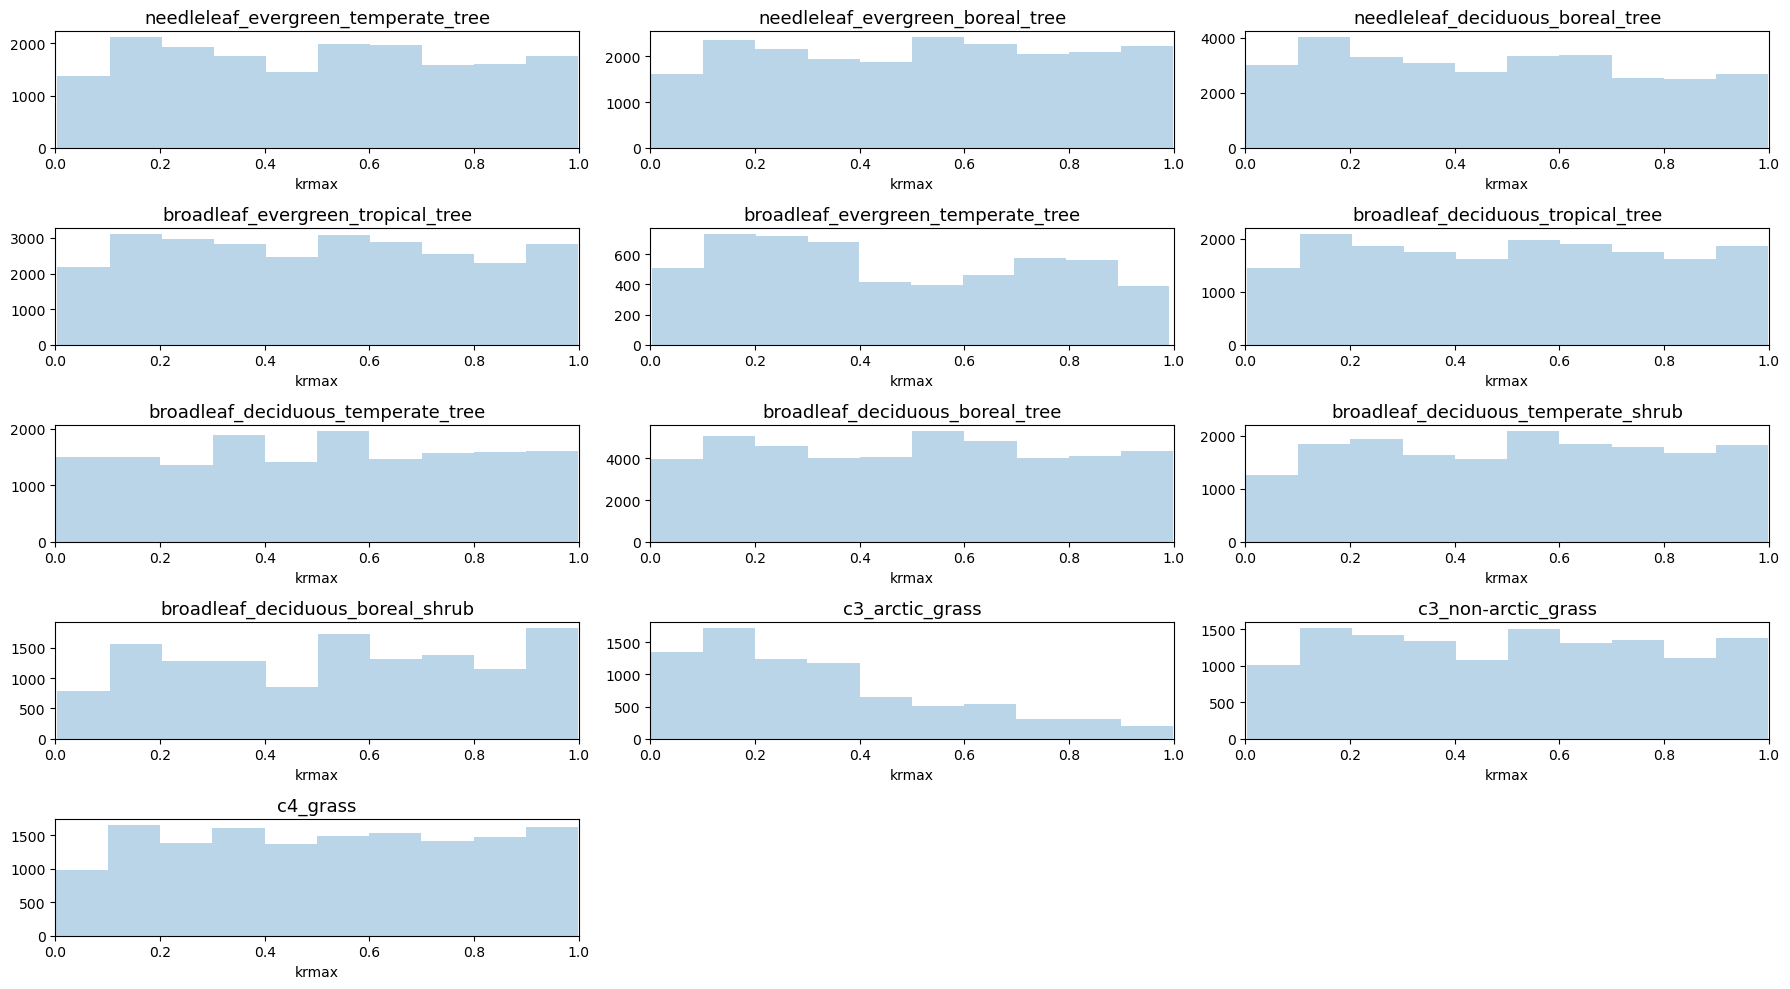

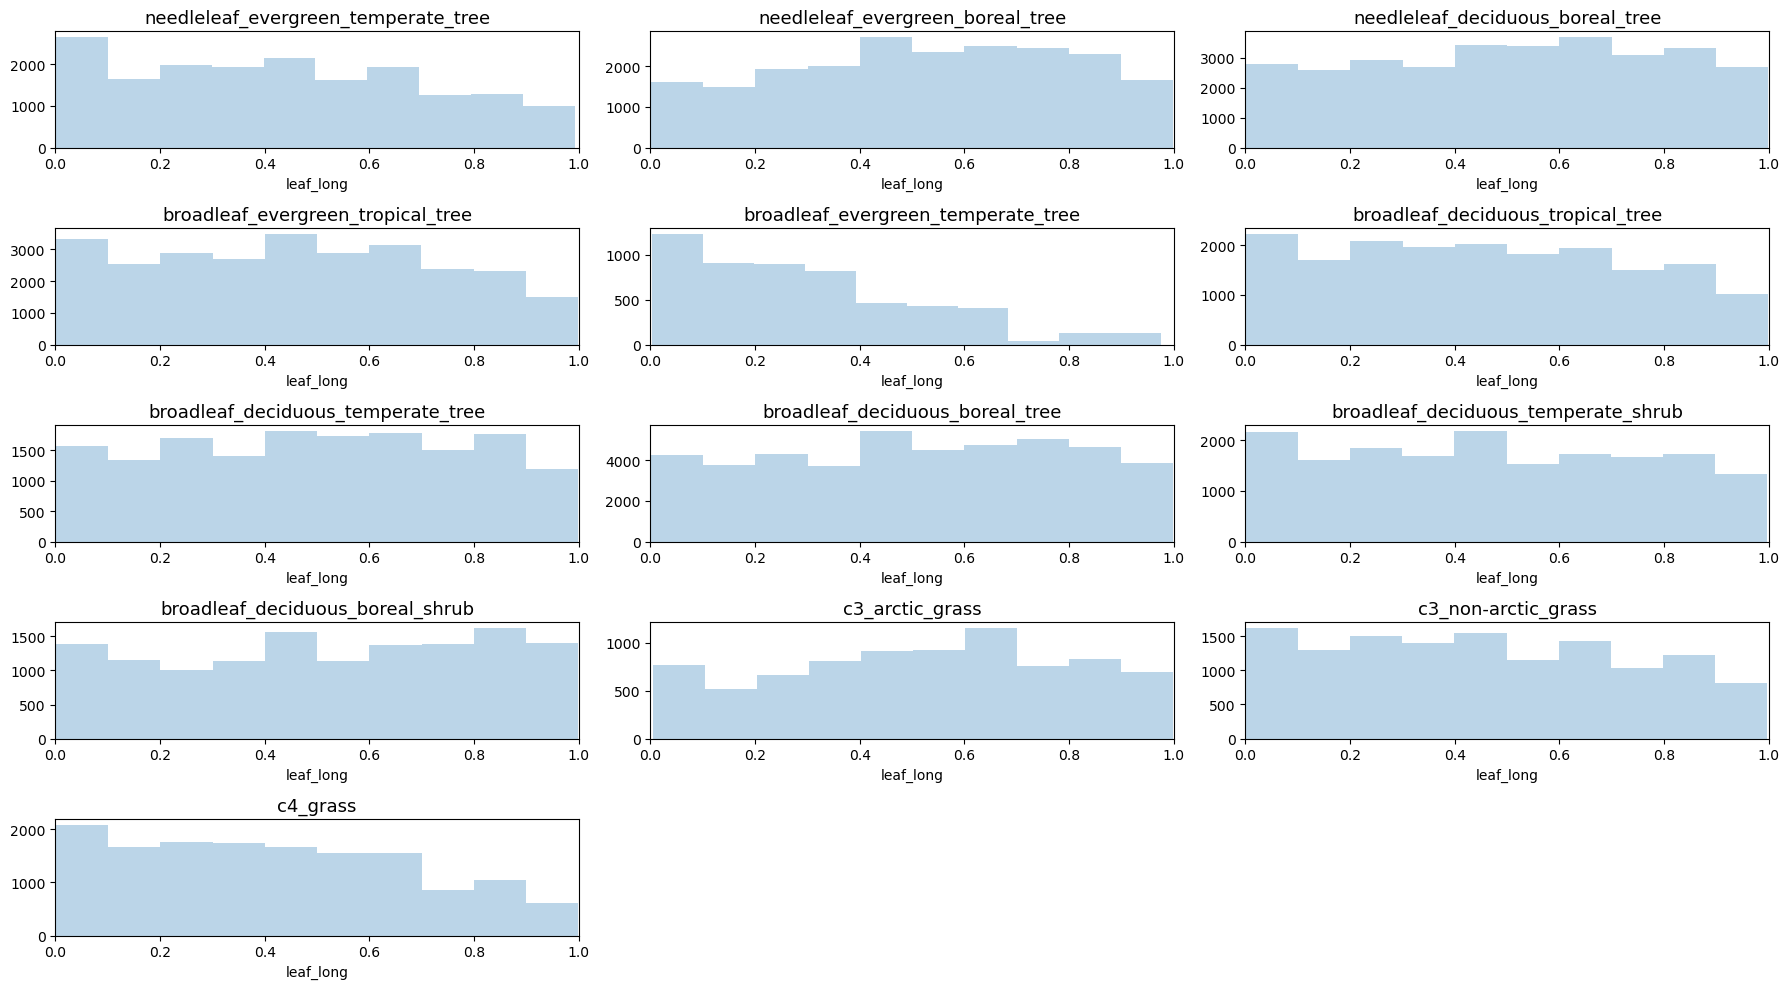

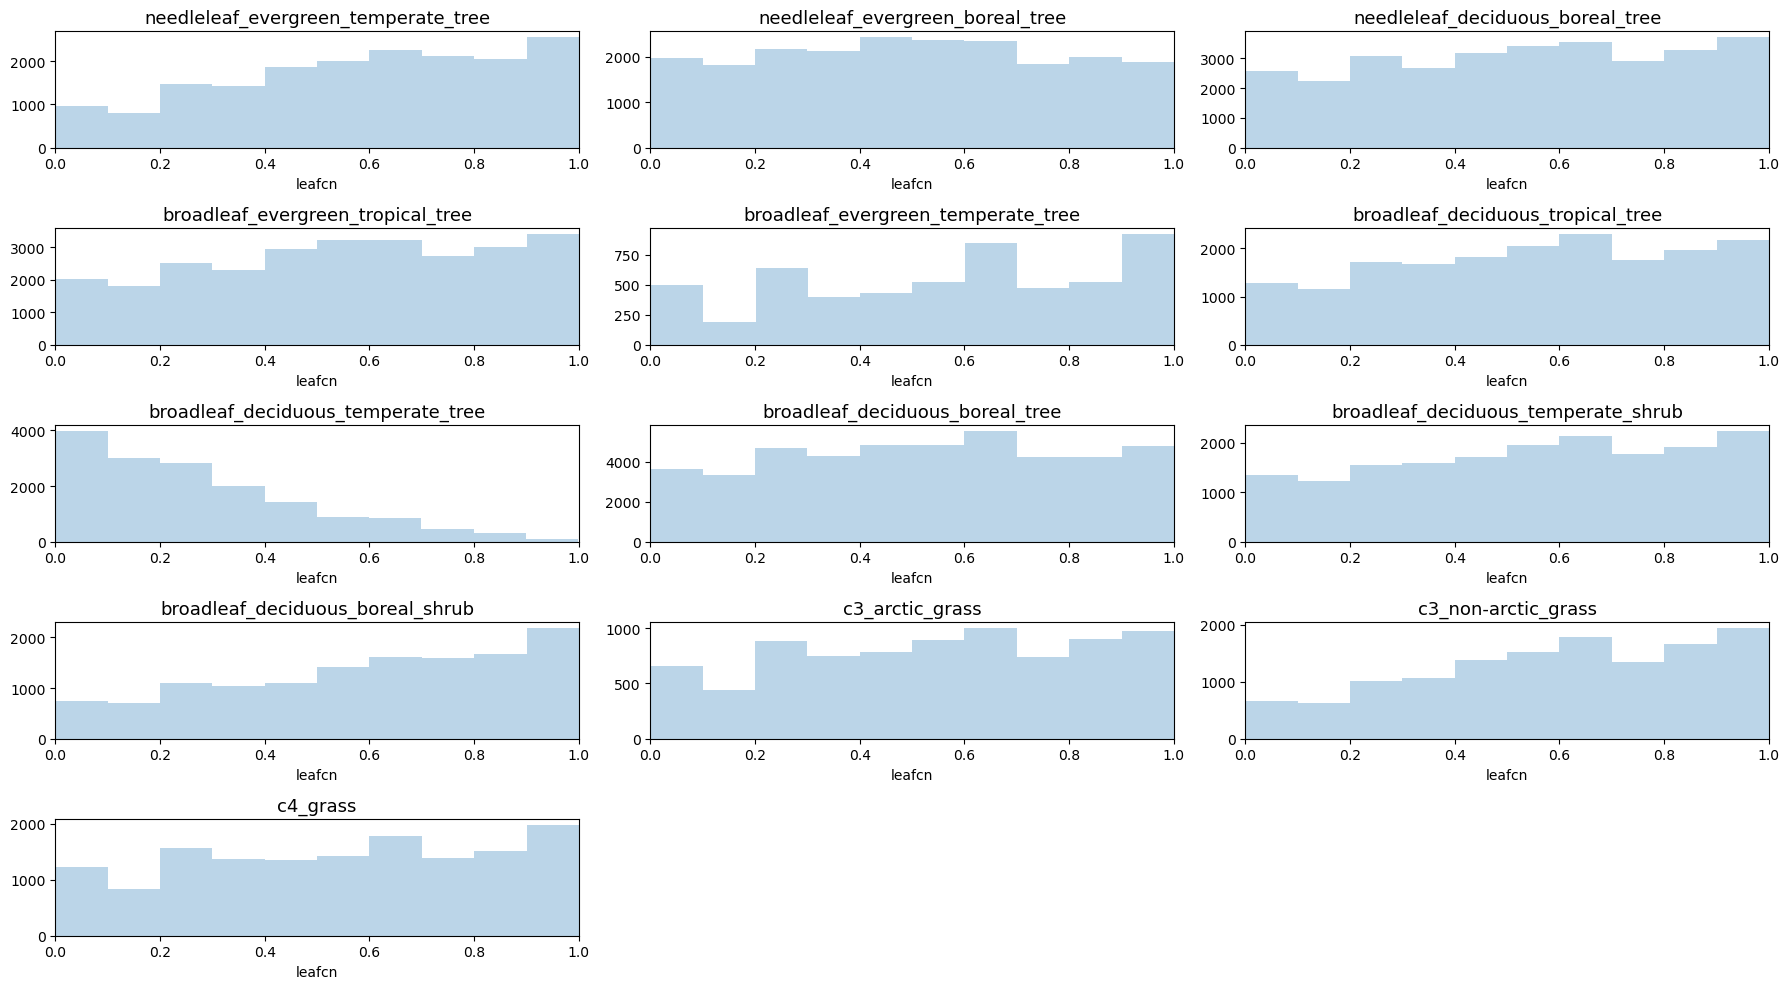

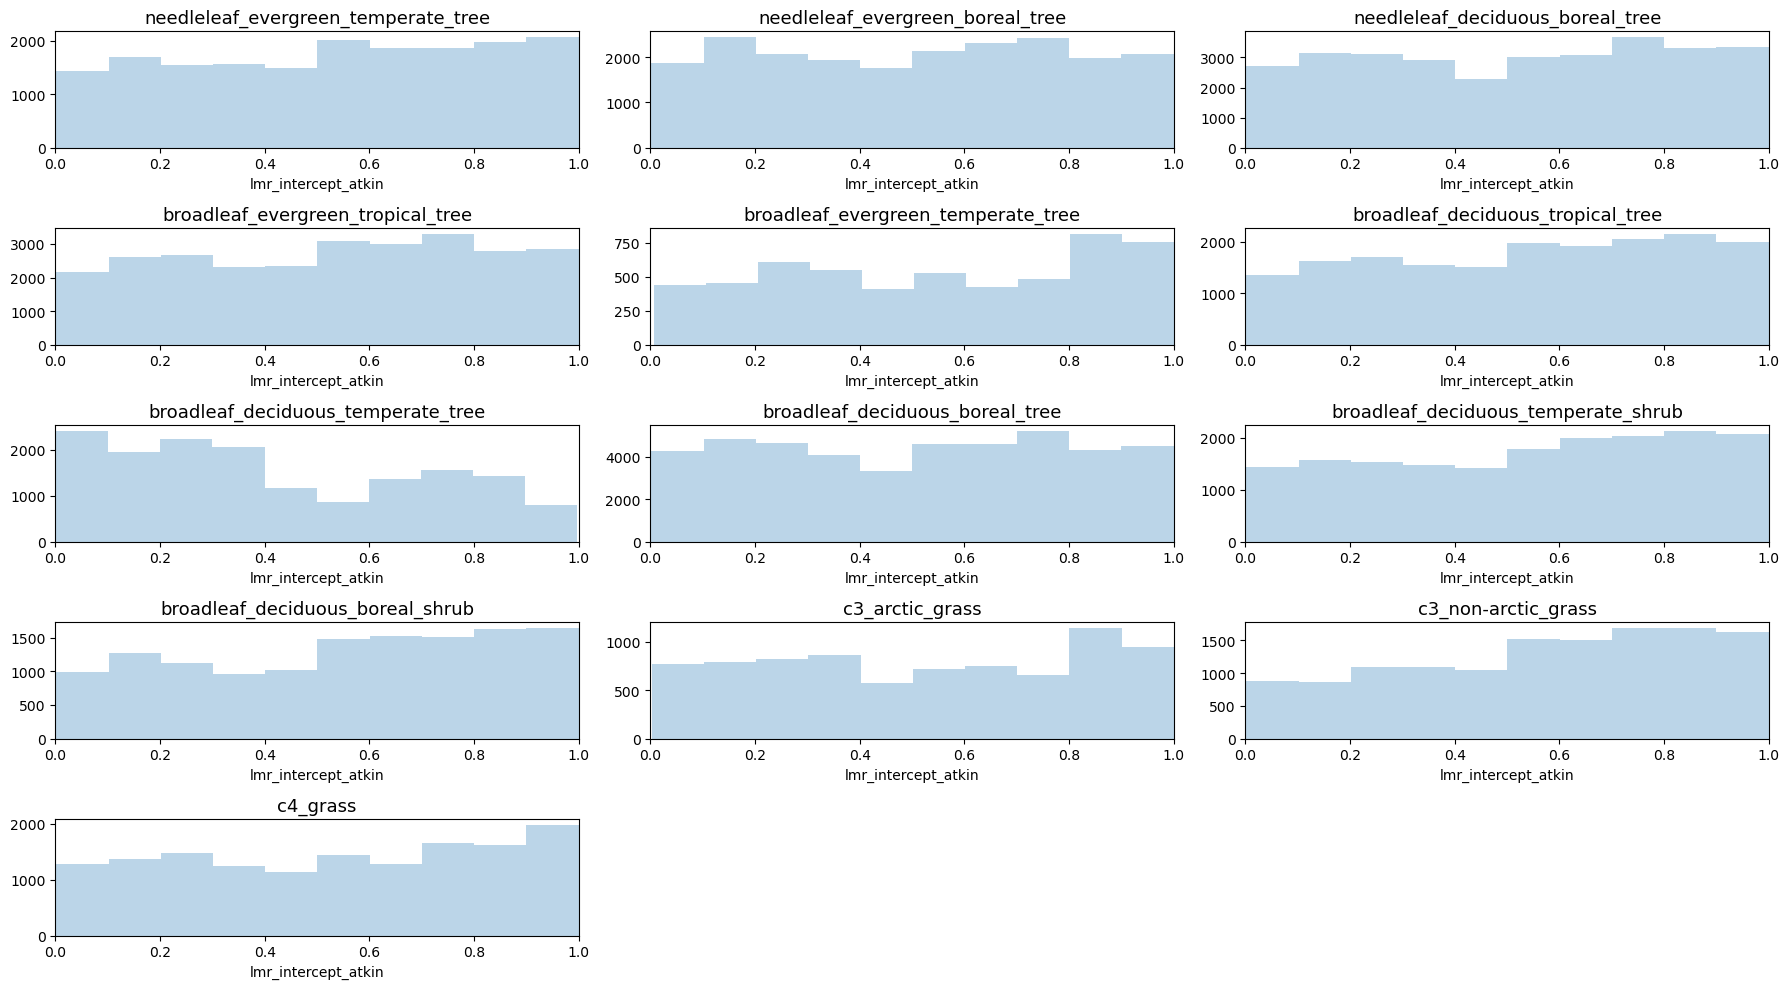

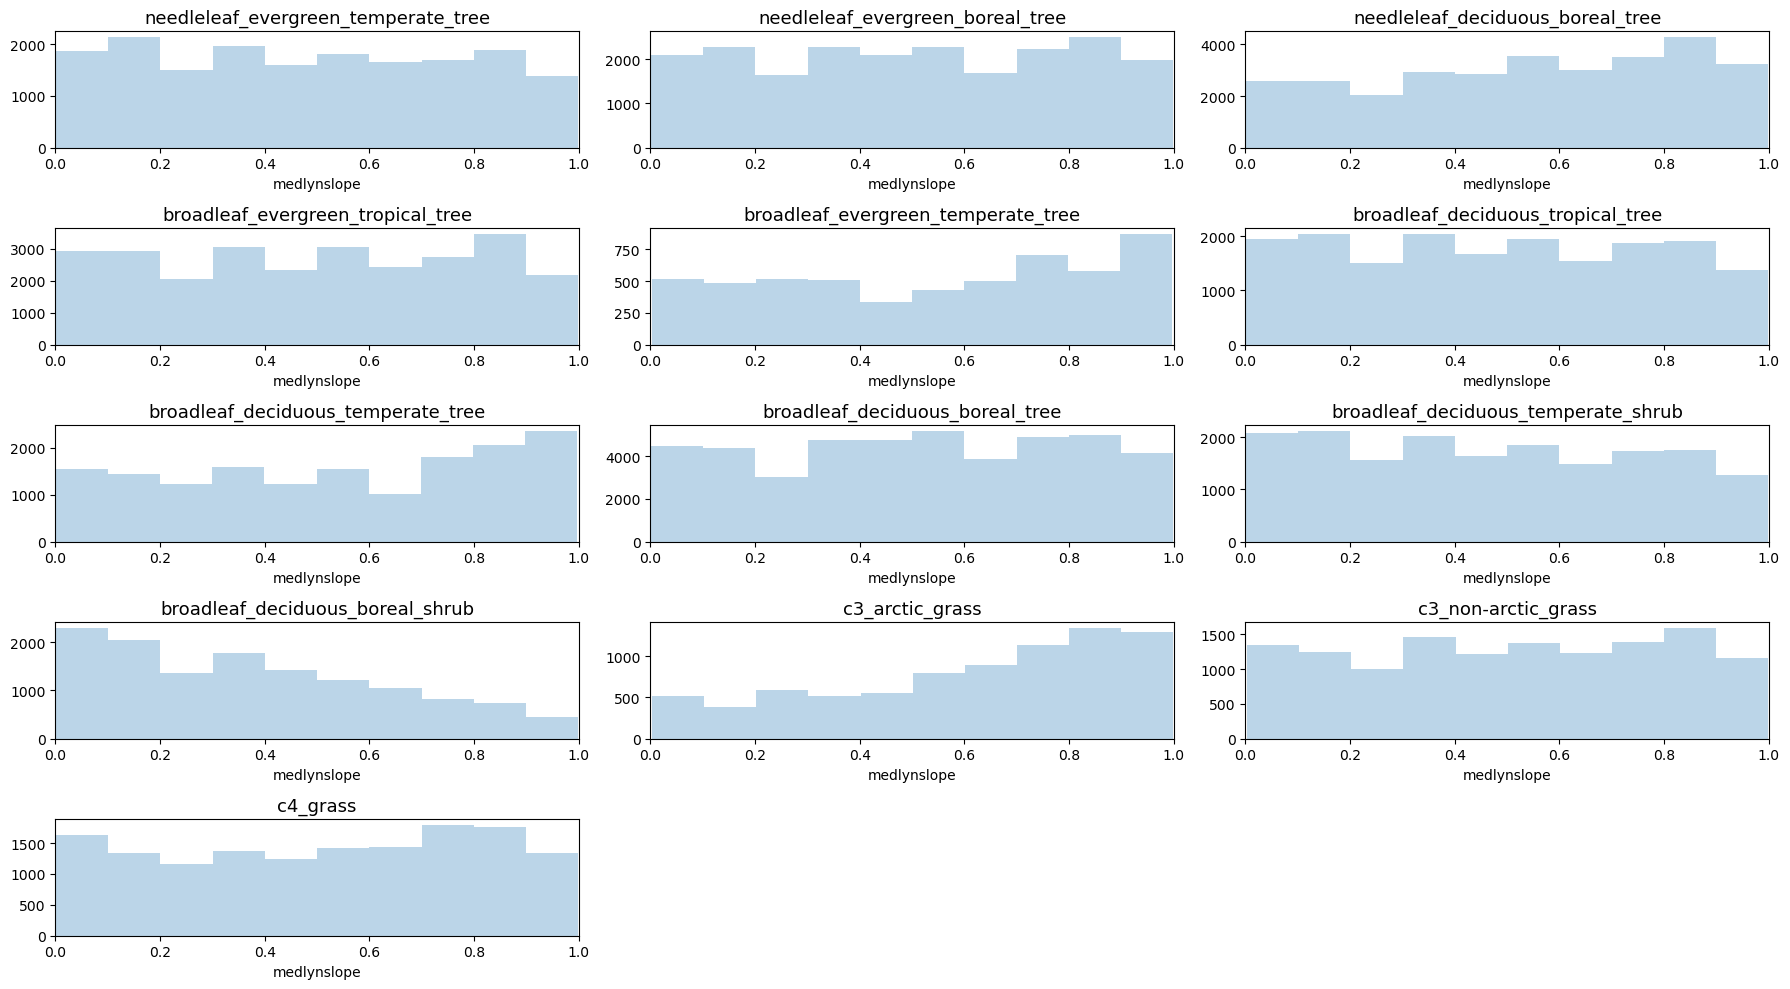

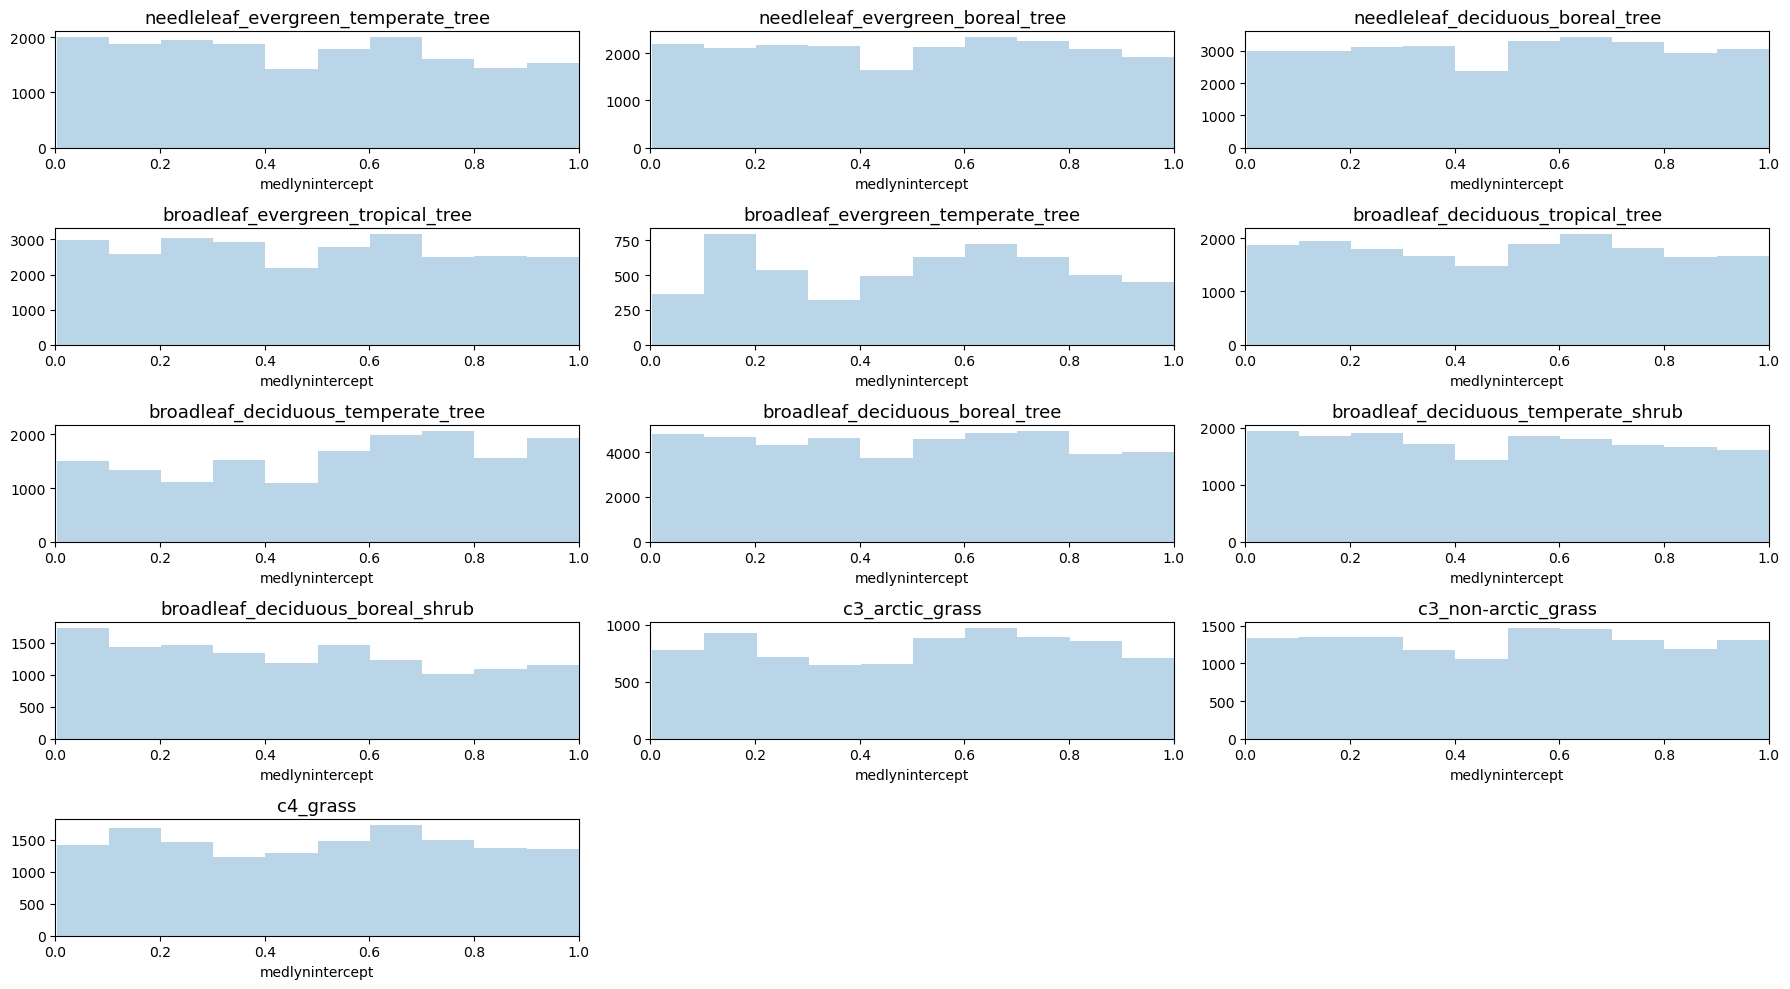

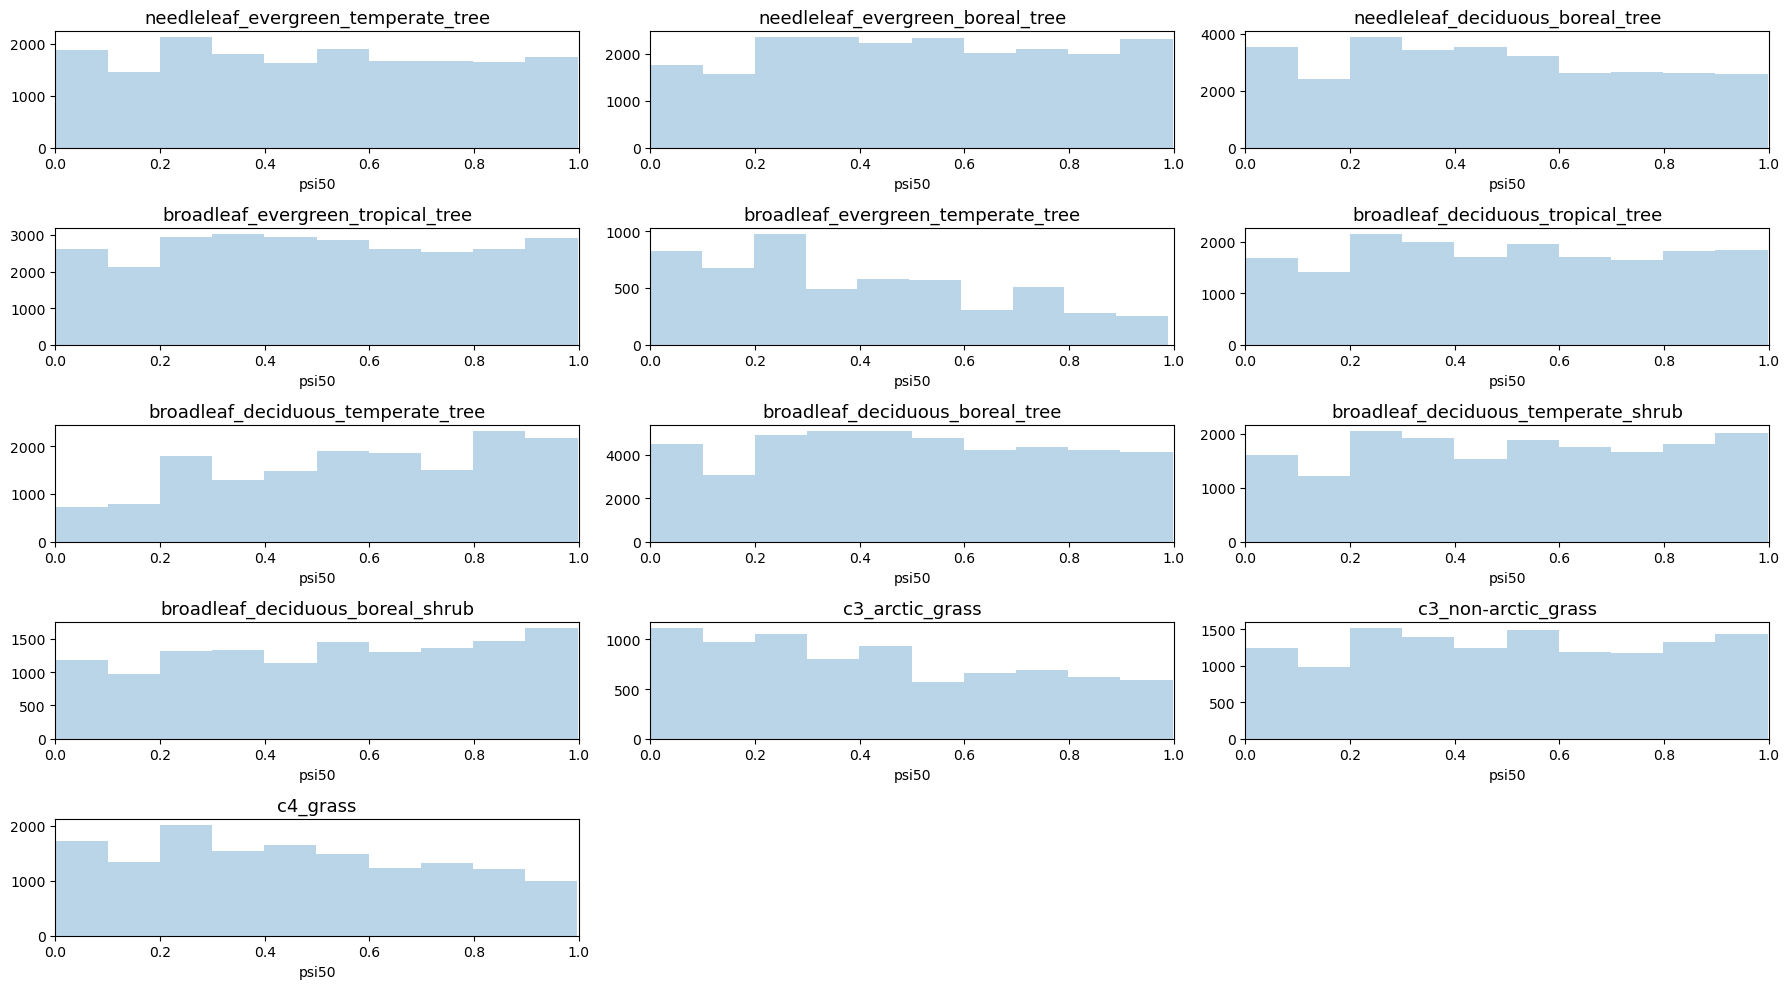

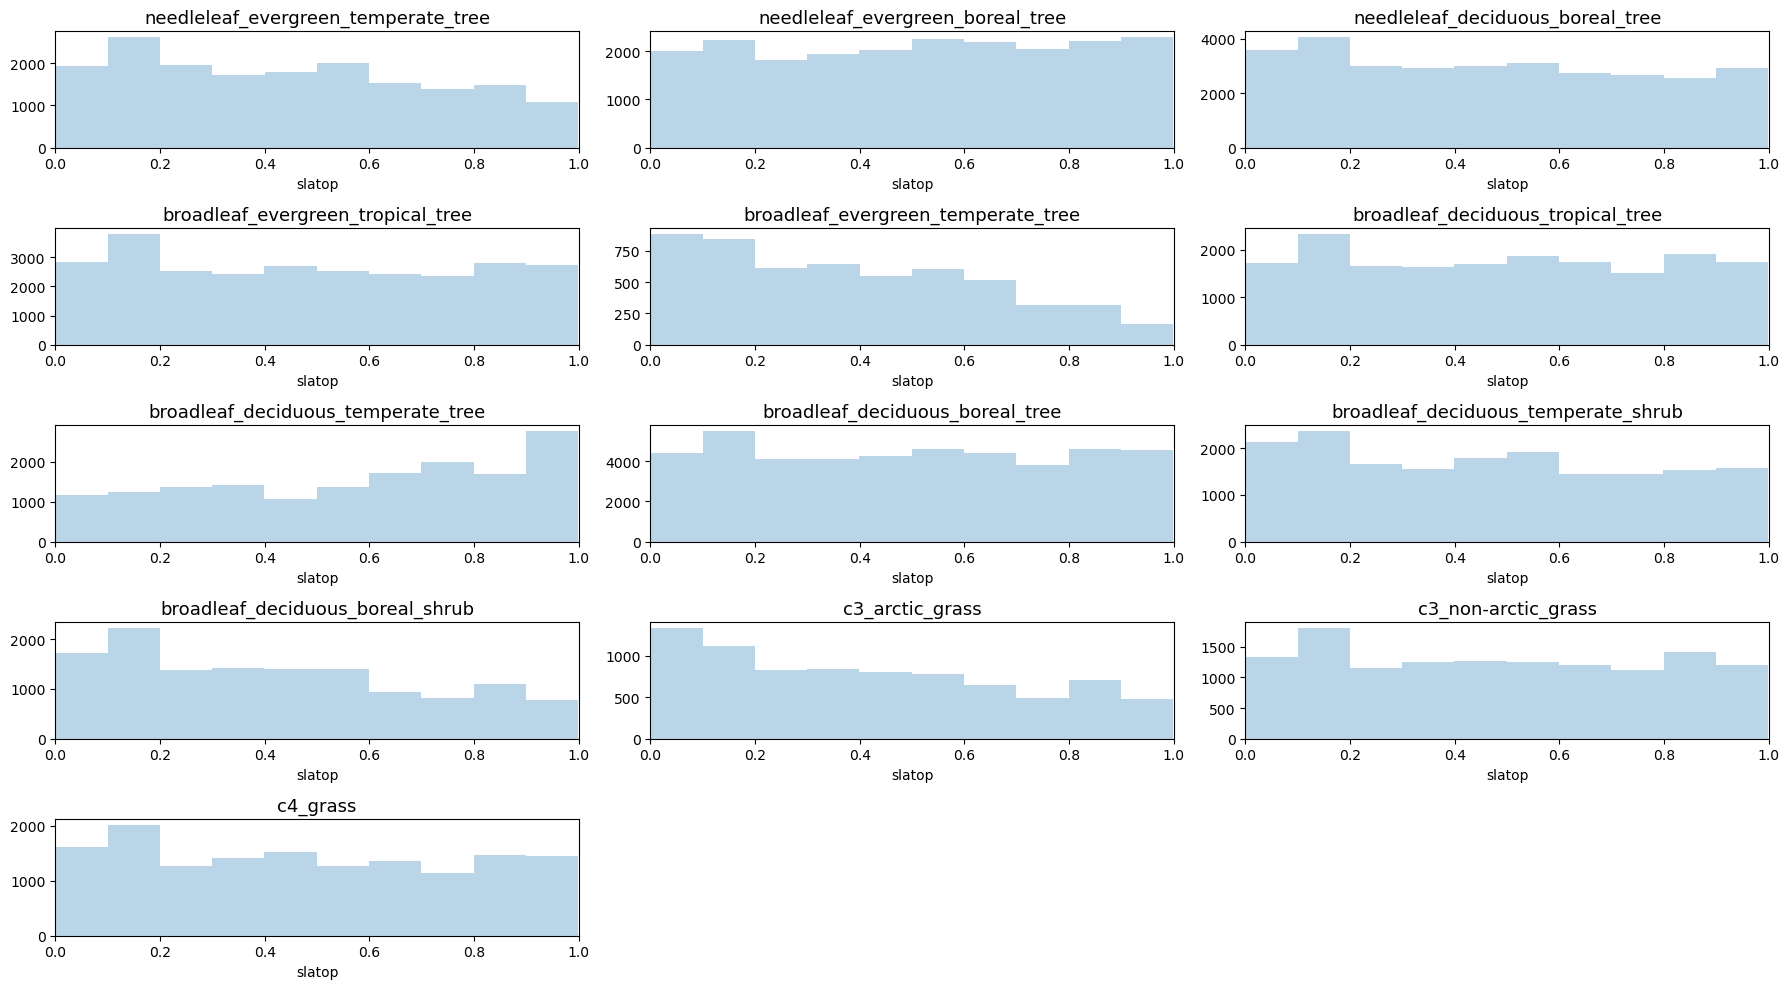

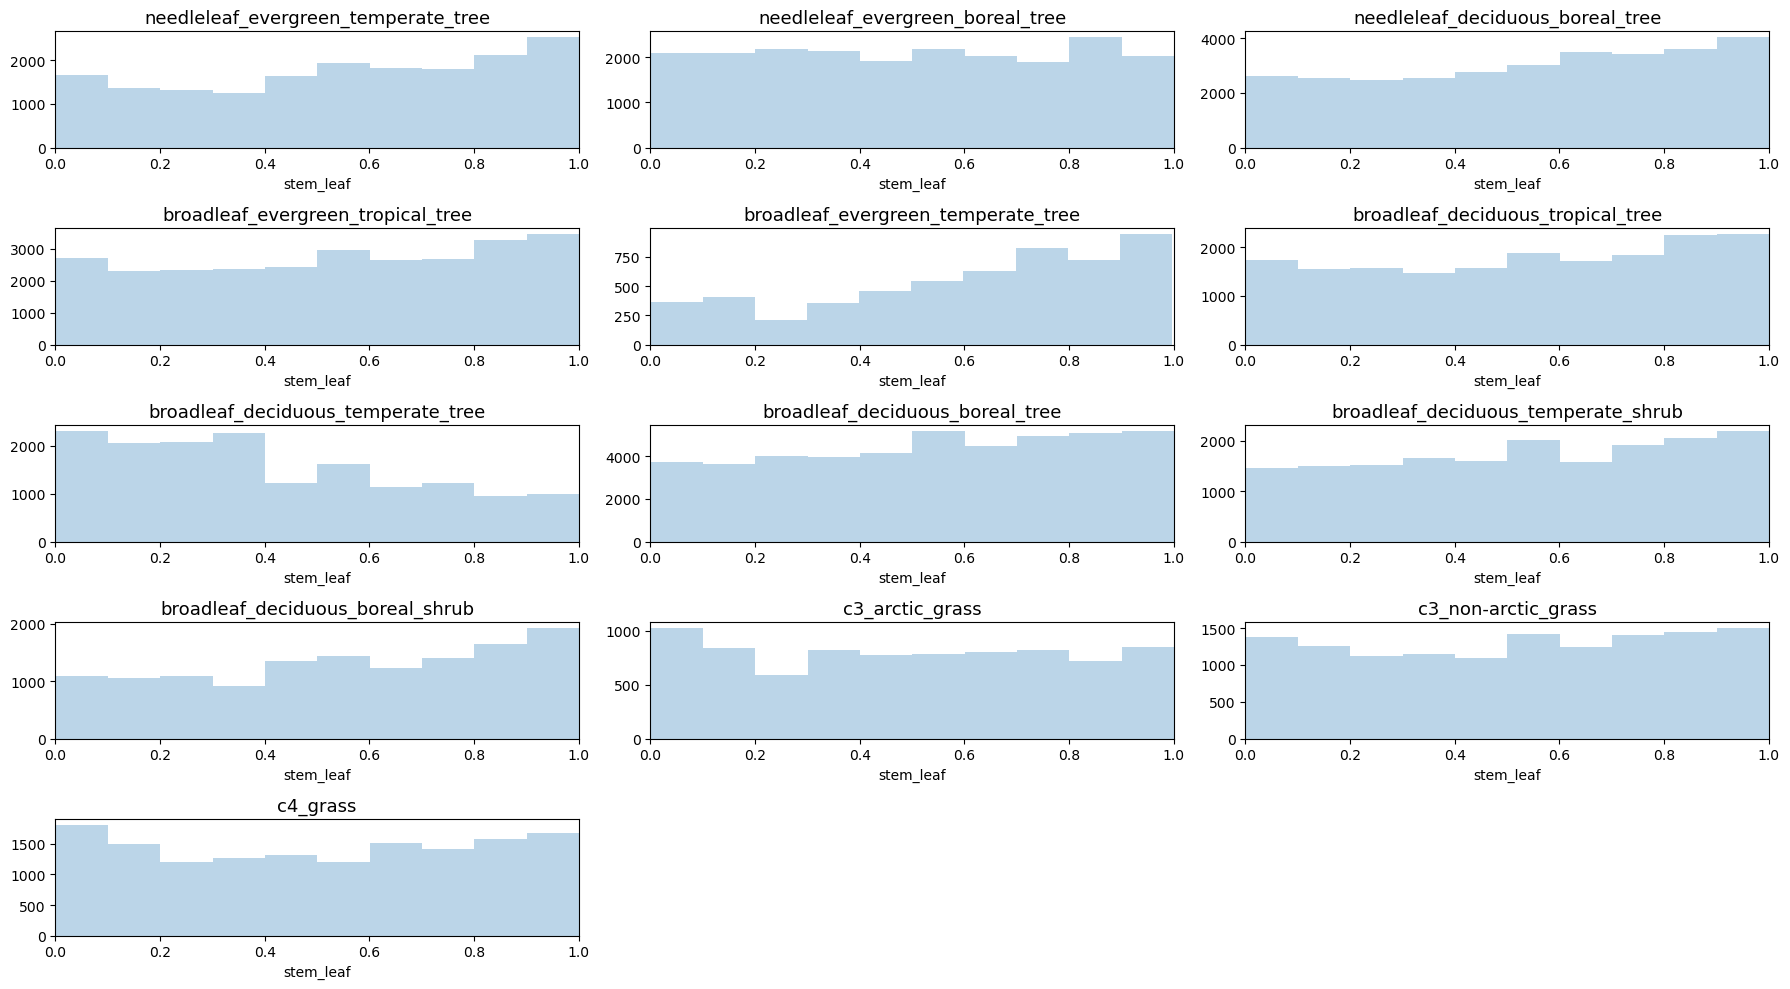

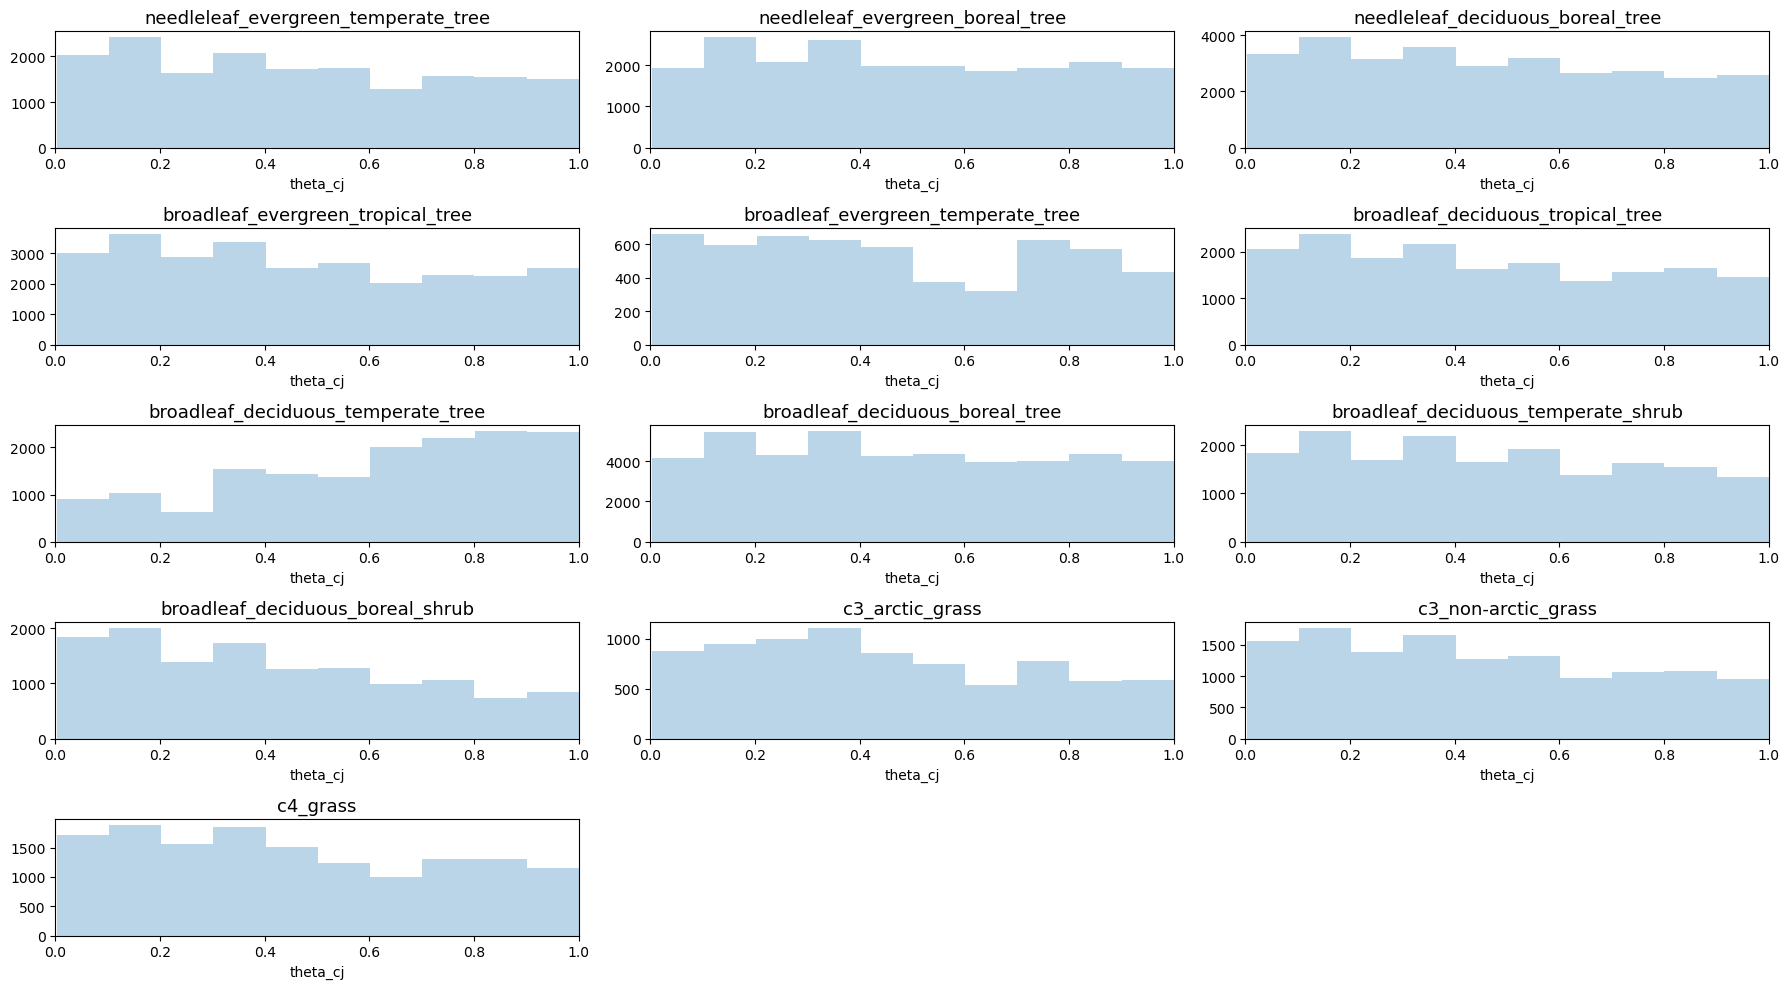

In [77]:
for i in range(len(pft_params)):
    plt.figure(figsize=[18,10])
    for p in range(13):
        plt.subplot(5,3,p+1)
        plt.hist(out_values[:,:,i,p].flatten(),alpha=0.3)
        plt.title(pfts[pft_ids[p]],fontsize=13)
        plt.xlim([0,1])
        #plt.ylim([0,400000])
        plt.xlabel(pft_params[i])
    plt.tight_layout()
    plt.savefig('./figs/'+pft_params[i]+'_1%.png')

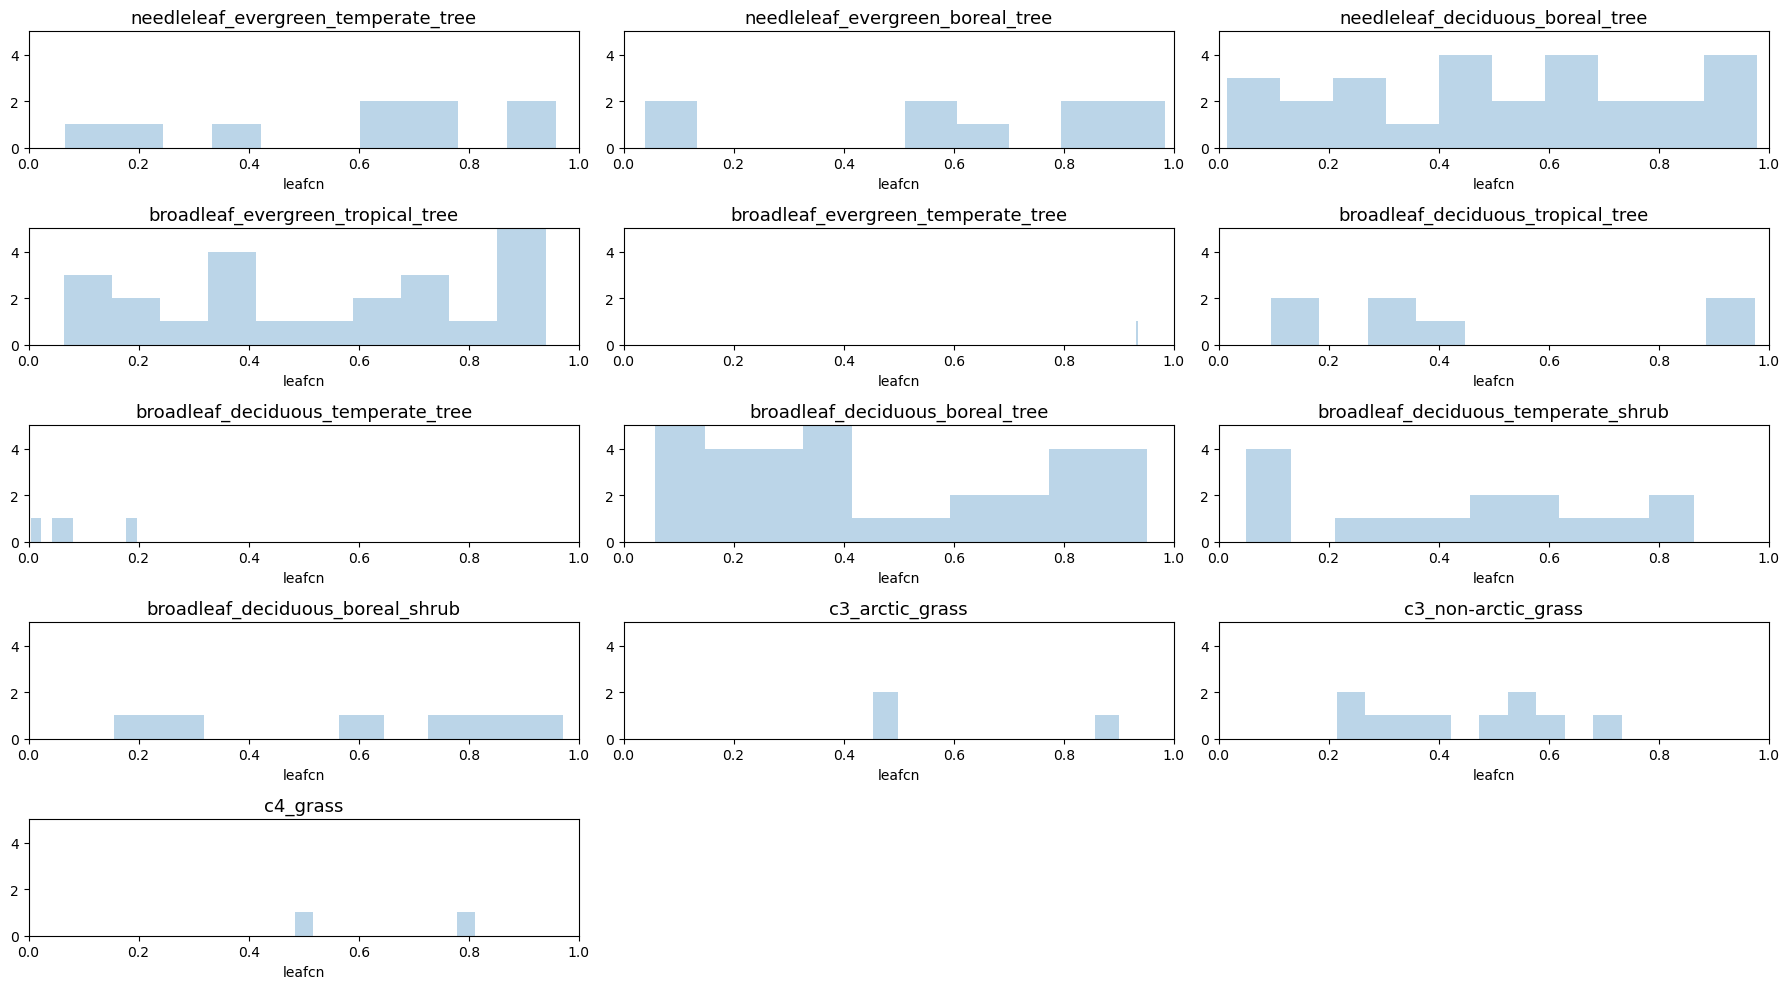

In [85]:
plt.figure(figsize=[18,10])
i=4
for p in range(13):
    plt.subplot(5,3,p+1)
    plt.hist(out_values[110,:,i,p].flatten(),alpha=0.3)
    plt.title(pfts[pft_ids[p]],fontsize=13)
    plt.xlim([0,1])
    plt.ylim([0,5])
    plt.xlabel(pft_params[i])
plt.tight_layout()
#plt.savefig('./figs/leafcn_1%_Uset1.png')

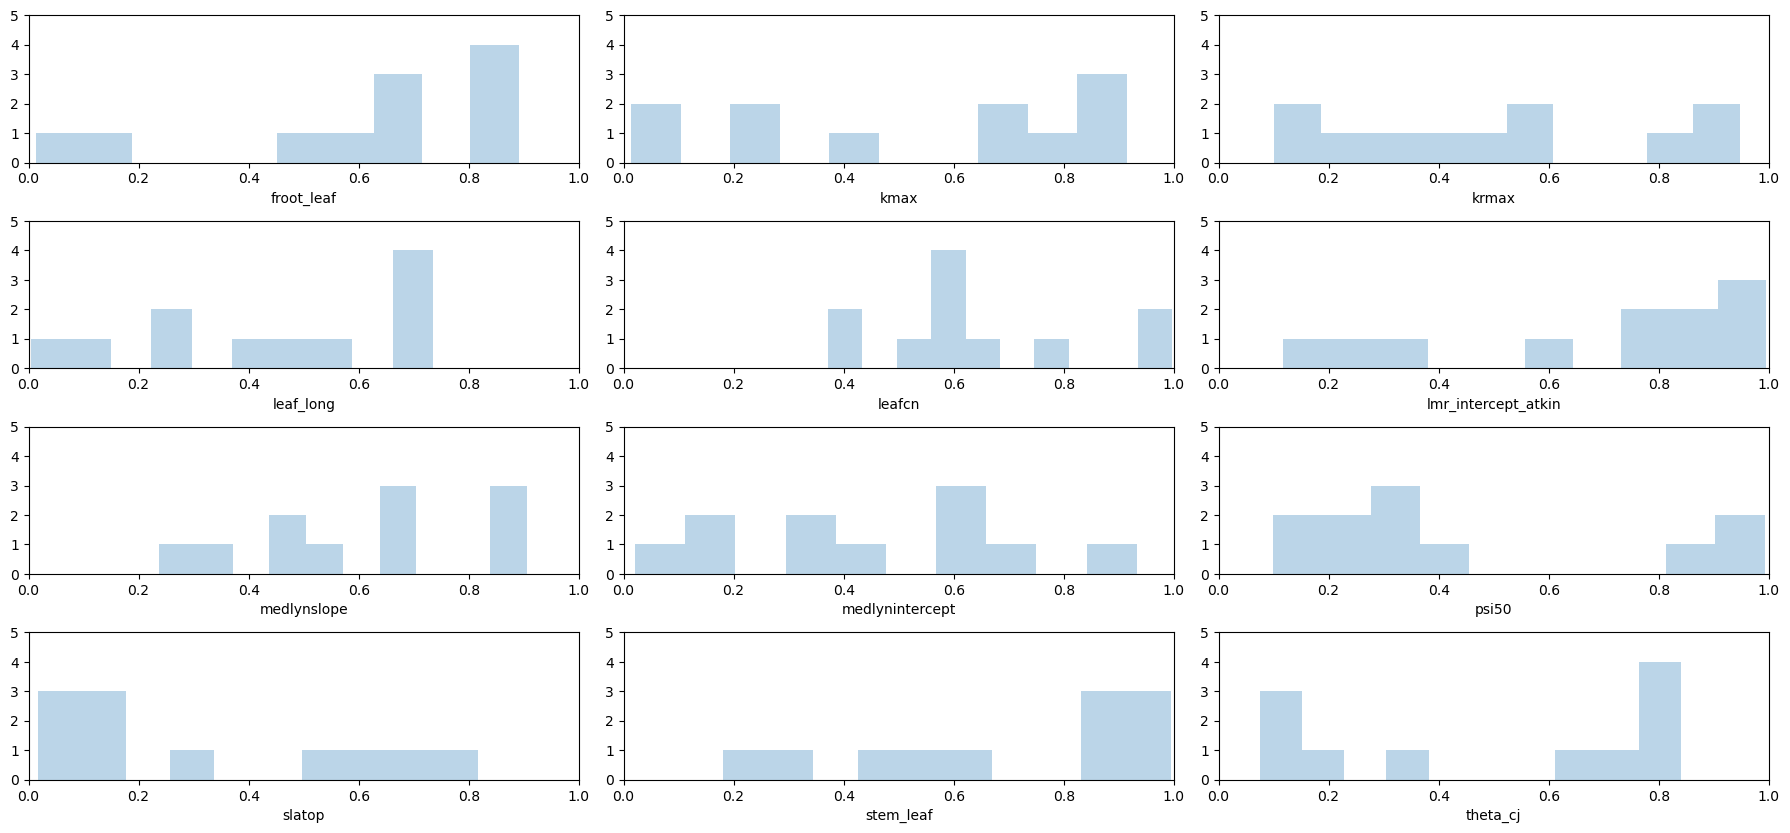

In [88]:
plt.figure(figsize=[18,10])
i=5
for p in range(12):
    plt.subplot(5,3,p+1)
    plt.hist(out_values[1,:,p,i].flatten(),alpha=0.3)
    #plt.title(pfts[pft_ids[p]],fontsize=13)
    plt.xlim([0,1])
    plt.ylim([0,5])
    plt.xlabel(pft_params[p])
plt.tight_layout()
#plt.savefig('./figs/leafcn_1%_Uset1.png')

### Sanity Check

In [137]:
fav_sets = np.load('pftLAI_psets_8-25.npy',allow_pickle=True).item()

In [138]:
fav_sets_r = np.empty((5,32,16))*np.NaN

for pft in range(1,15):
    for u in range(5):
        a=[] ; b=[]
        for i,up in enumerate(u_params):
            a.append(fav_sets[up][u])
        for i,pp in enumerate(pft_params):
            b.append(fav_sets[pp][u][pft])
        fav_sets_r[u,:,pft] = np.hstack([a,b])

In [144]:
# Check if loaded emulator gives identical predicted PFT LAI for sub-sample
p=16
s = fav_sets_r[:,:,14]
y_pred_st, _ = emulator.predict_f(s)
#y_pred_st, _ = PFT_emulator_dict[pfts[p]].compiled_predict_y(s) 
y_pred_st

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[-1.62358029],
       [-1.70617942],
       [ 0.79435905],
       [-1.60702565],
       [-1.94668364]])>

In [115]:
p=1
s = fav_sets_r[:,:,p]
loaded_emulator = tf.saved_model.load('./models/'+pfts[p]+'/')
y_pred_st, _ = loaded_emulator.compiled_predict_y(s) 

In [116]:
y_pred_st

<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[-0.21280078],
       [-0.34478986],
       [-1.16321602],
       [-0.35978594],
       [ 0.20040699]])>

### Check GPP 

#### Load CLM-PPE GPP data

In [6]:
# CLM-PPE
dvs=['GPP']
htape='h1'
yr0=2007
yr1=2013
ds=get_exp('transient',dvs=dvs,tape=htape,yy=(yr0,yr1))

In [7]:
t=slice(str(yr0),str(yr1))
da=ds.GPP.sel(time=t)
la=xr.open_dataset('landarea_transient.nc').landarea_pft.sel(time=t)
amean_gpp=amean(da).mean(dim='year').compute()
PPE_gpp = pmean(amean_gpp,la).mean(dim='time').compute()

#### Load Target Data

In [8]:
#Load ILAMB GPP datasets
ds_gpp_ilamb =xr.open_dataset('/glade/work/linnia/ILAMB/ilamb_data/regridded/ILAMB_GPP_regridded_v3.nc')

In [9]:
la=xr.open_dataset('../sparsegrid_landarea.nc').landarea
ilamb_cf=1e-9*365

In [10]:
jvals, ivals = get_sparsegrid()
FLX_gpp = ilamb_cf*amean(ds_gpp_ilamb.FLUXCOM_GPP[:,jvals,ivals]).mean(dim='year').compute()
wecann_gpp = ilamb_cf*amean(ds_gpp_ilamb.WECANN_GPP[:,jvals,ivals]).mean(dim='year').compute()

#### Train GPP emulators

In [17]:
# Define kernels
kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),variance=1)
kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), variance=1, lengthscales = np.tile(1,32))
kernel_matern52 = gpflow.kernels.Matern52(active_dims=range(num_params),variance=1,lengthscales=np.tile(1,32))
kernel_RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

# select the kernal to use
kernel = kernel_linear + kernel_matern32 + kernel_RBF

2023-08-16 17:03:39.732080: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-08-16 17:03:39.732134: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc61): /proc/driver/nvidia/version does not exist
2023-08-16 17:03:39.790014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: /glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/models_gpp/needleleaf_evergreen_temperate_tree/assets
INFO:tensorflow:Assets written to: /glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/models_gpp/needleleaf_evergreen_boreal_tree/assets
INFO:tensorflow:Assets written to: /glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/models_gpp/needleleaf_deciduous_boreal_tree/assets
INFO:tensorflow:Assets written to: /glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/models_gpp/broadleaf_evergreen_tropical_tree/assets
INFO:tensorflow:Assets written to: /glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/models_gpp/broadleaf_evergreen_temperate_tree/assets
INFO:tensorflow:Assets written to: /glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/models_gpp/broadleaf_deciduous_tropical_tree/assets
INFO:tensorflow:Assets written to: /glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/models_gpp/broadleaf_deciduous_temperate_tree/assets
INFO:tensorflow:Assets written to: /glade/work/linnia/CLM-PPE-LAI_t

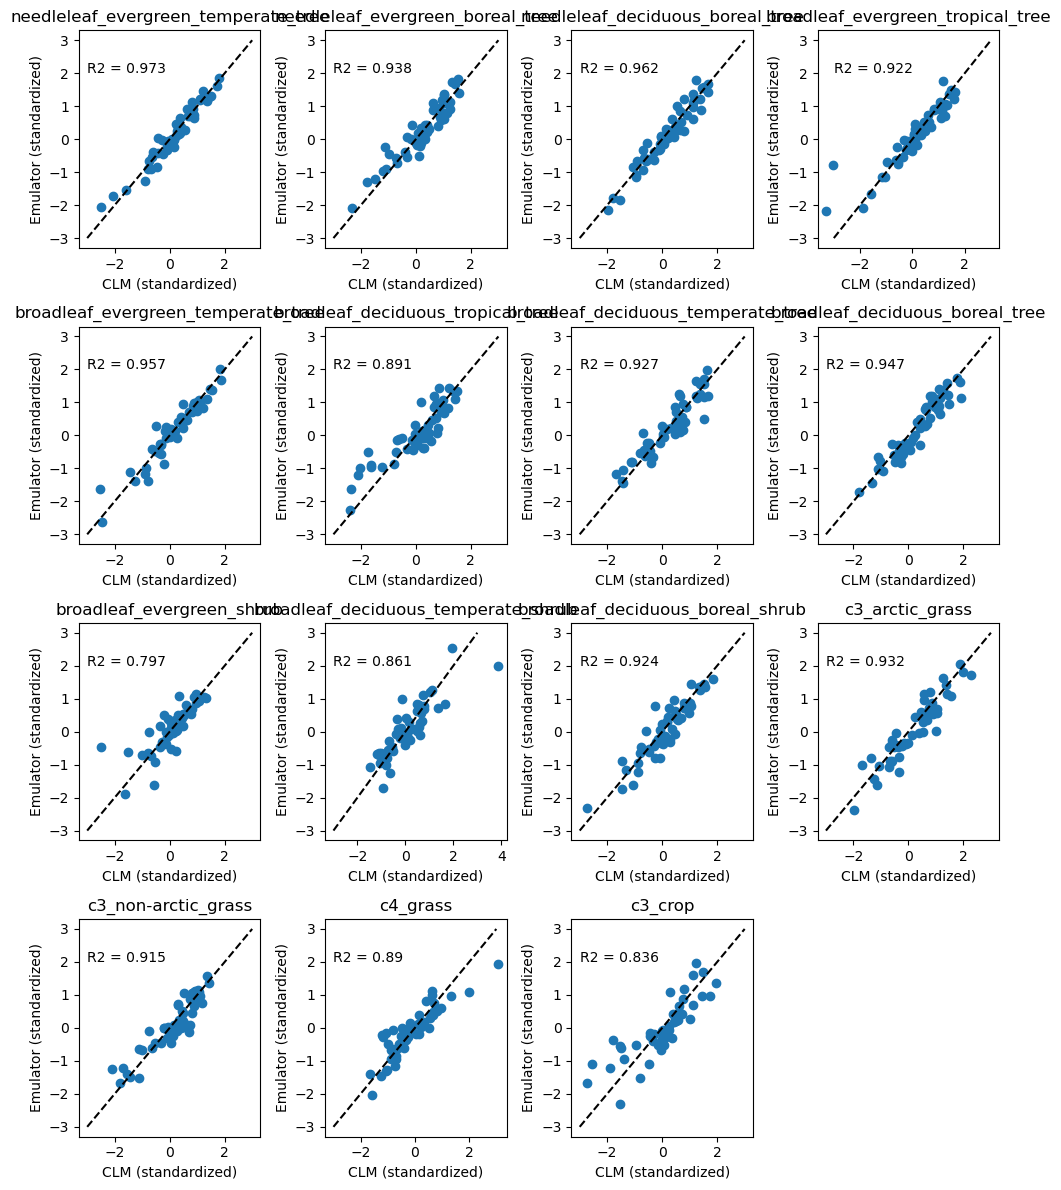

In [19]:
# train emulators (using GPFlow)

plt.figure(figsize=[10,12])
plt.rcParams.update({'font.size': 10})

PFT_GPP_emulator_dict = {}
keys = pfts

for i in range(1,16):

    y_data = PPE_gpp.sel(pft=i)
    
    ax = plt.subplot(4,4,i)
    savedir = str('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/models_gpp/'+keys[i])

    emulator = trainGP_GPFlow(y_data[1:],ppe_params,50,ax,kernel,savedir)
    
    PFT_GPP_emulator_dict[keys[i]] = emulator
    
    ax.set_title(pfts[i])

plt.tight_layout()
plt.savefig('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/PFT_GPPmax_emulator_validation_GPflow.png',dpi = 100)

#### predict sample

In [22]:
#load sample
u_sample= np.loadtxt('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/universal_sample_8-15.txt',delimiter=',')
n_usamp = len(u_sample)

pft_sample= np.loadtxt('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/pft_sample_8-15.txt',delimiter=',')
n_psamp = len(pft_sample)

In [23]:
n_pfts = 16
n_batch = 10
batch_size = np.int(n_usamp/n_batch)

# allocate output array
PFT_pred_GPP = np.empty([n_usamp,n_psamp,n_pfts])

In [25]:
%%time

#loop through batches
st = 0
for i in range(n_batch):
    en = np.int(st+batch_size)
    print(en)

    tmp_samp = np.concatenate((np.repeat(u_sample[st:en,:],n_psamp,axis=0),np.tile(pft_sample,(batch_size,1))),axis=1)
    for j,p in enumerate(pfts[1:15]):
        y_pred_std, _ = PFT_GPP_emulator_dict[p].predict_f(tmp_samp) 
        #y_pred_std, _ = PFT_GPP_emulator_dict[p].predict(tmp_samp) 
        y_pred = unstandardize(np.array(y_pred_std).reshape(1,-1),PPE_gpp.sel(pft=j+1))
        PFT_pred_GPP[st:en,:,j+1] = np.reshape(y_pred,(batch_size,n_psamp))
    
    st = st+batch_size

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
CPU times: user 1h 53min 36s, sys: 1min 11s, total: 1h 54min 47s
Wall time: 1h 57min 16s


In [27]:
np.save('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/PFT_pred_GPP_8-15.npy',PFT_pred_GPP)

#### Score

In [69]:
#calculate the fractional bias 
fbias_gpp = np.empty(np.shape(PFT_pred_GPP))
tmp = np.tile(PPE_gpp[1:17,0],(n_psamp,1)) # use Default CLM GPP as Target
for i in range(n_usamp):
    var = PFT_pred_GPP[i,:,:]
    fbias_gpp[i,:,:] = (var-tmp)/tmp

In [70]:
fbias_lai_ix = np.abs(fbias[out,:,:]) < 0.01

In [71]:
fbias_gpp_in = fbias_gpp[out,:,:]
fbias_lai_in = fbias[out,:,:]

In [ ]:
# plot fractional bias LAI v GPP
plt.figure(figsize=[12,8])
for i in range(1,15):
    plt.subplot(3,5,i)
    plt.scatter(fbias[:,:,i].flatten(),fbias_gpp[:,:,i].flatten(),color='grey',alpha=0.4)
    plt.scatter(fbias[out,:,i].flatten(),fbias_gpp[out,:,i].flatten(),color='peru',alpha = 0.8)
    sets = fbias_lai_ix[:,:,i]
    lai_var = fbias_lai_in[:,:,i]
    gpp_var = fbias_gpp_in[:,:,i]
    plt.scatter(lai_var[sets].flatten(),gpp_var[sets].flatten(),color='green')
    # add default model and LHC sample
    plt.plot([-6,6],[0,0],linestyle='--',color='grey')
    plt.plot([0,0],[-4,4],linestyle='--',color='grey')
    plt.xlabel('LAI fractional error')
    plt.ylabel('GPP fractional error')
    plt.title(pfts[i],fontsize=10)
    plt.xlim([-6,6])
    plt.ylim([-4,4])
    
plt.tight_layout()
plt.savefig('./figs/fbias_GPPvLAI_8-15_1%.png',dpi=100)

### Constrain with Global GPP

In [111]:
# Sum predicted GPP across PFTs
la_pft=xr.open_dataset('landarea_transient.nc').landarea_pft.sel(time=t)
la_pft = la_pft.isel(time=1)
tmp = pmean(la_pft,la_pft)

a = np.empty(np.shape(PFT_pred_GPP))
for p in range(1,16):
    cf_la = tmp[p].values
    a[:,:,p] = cf_la*PFT_pred_GPP[:,:,p]
    
pred_GM_gpp = a.sum(axis=2)

In [166]:
# load global mean FLUXCOM and WECANN
ds_gpp_ilamb =xr.open_dataset('/glade/work/linnia/ILAMB/ilamb_data/regridded/ILAMB_GPP_regridded_v3.nc')

la=xr.open_dataset('../sparsegrid_landarea.nc').landarea
ilamb_cf=1e-9*la.sum()*365
jvals, ivals = get_sparsegrid()

FLX_gpp = ilamb_cf*gmean(amean(ds_gpp_ilamb.FLUXCOM_GPP[:,jvals,ivals]).mean(dim='year'),la).compute()
wecann_gpp = ilamb_cf*gmean(amean(ds_gpp_ilamb.WECANN_GPP[:,jvals,ivals]).mean(dim='year'),la).compute()

obs_error = wecann_gpp - FLX_gpp
#obounds = [FLX_gpp-obs_error, wecann_gpp+obs_error]
obounds = [FLX_gpp, wecann_gpp]

In [167]:
# Constrain and plot
ix=np.empty((10000,1000))
ix[:]=np.nan
for u in range(10000): 
    for p in range(1000):
        val = pred_GM_gpp[u,p]
        
        if (val>obounds[0].values):
            if (val<obounds[1].values):
                ix[u,p] = 1


In [168]:
# Find global sets that are within PFT specific tolerances
sets = ~np.isnan(ix)

In [169]:
passing_usets = sets.sum(axis=1)
min(passing_usets)

6

### Select favorite

In [180]:
in_var = fbias_gpp[out,:,p]
np.shape(in_var)

(1650, 1000)

In [184]:
in_var = fbias_gpp[out,:,p]
idx = (np.abs(in_var + 0.5)).argmin()
np.unravel_index(idx, in_var.shape)

(789, 243)

In [199]:
ppe_params.columns[0:20]

Index(['FUN_fracfixers', 'KCN', 'a_fix', 'crit_dayl', 'd_max', 'fff',
       'fstor2tran', 'grperc', 'jmaxb0', 'jmaxb1', 'kcha', 'lmrha', 'lmrhd',
       'nstem', 'q10_mr', 'soilpsi_off', 'sucsat_sf', 'tpu25ratio', 'tpuse_sf',
       'wc2wjb0'],
      dtype='object')

In [189]:
np.shape(pft_sample)

(1000, 12)

In [200]:
np.savetxt('Uset_c4.csv',np.transpose(Usets[789,:]),delimiter = ",")
np.savetxt('Pset_c4.csv',np.transpose(pft_sample[243,:]),delimiter = ',')

(array([7.60000e+01, 1.46100e+03, 1.46940e+04, 1.08156e+05, 4.04221e+05,
        5.85809e+05, 3.85660e+05, 1.31580e+05, 1.77460e+04, 5.97000e+02]),
 array([-1.27733945, -1.14596367, -1.01458789, -0.88321211, -0.75183634,
        -0.62046056, -0.48908478, -0.357709  , -0.22633322, -0.09495745,
         0.03641833]),
 <BarContainer object of 10 artists>)

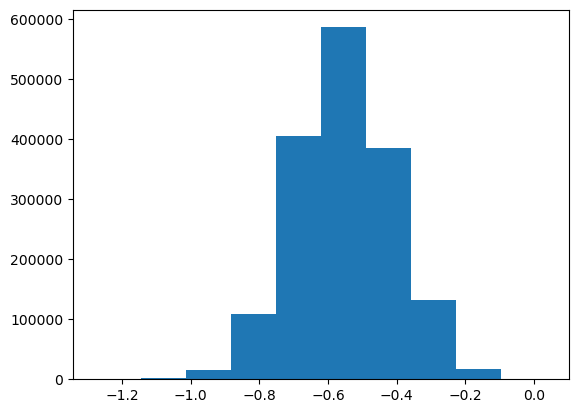

In [177]:
p=13 # C3 arctic grass
in_var = fbias_gpp[out,:,p]
for u in range(np.shape(in_var)[0]):
    for 
        if (val>obounds[0].values):
            if (val<obounds[1].values):
                ix[u,p] = 1


In [174]:
# what global sets allow us to get low C3 arctic grass?
# build array of all passing parameter sets, parameter values
ppe_params_pass_13 = np.tile(0,32)
p = 13
for i in range(len(Usets)):
        pft_pass_ix = np.where(PFTsample_ix[i,:,p])
        tiled_usets = np.tile(Usets[i,:],np.shape(pft_pass_ix)[1])
        tiled_usets = tiled_usets.reshape(np.shape(pft_pass_ix)[1],len(Usets[i,:]))
        
        pft_sample_pass = pft_sample[pft_pass_ix,:]
        if np.shape(pft_sample_pass)[1] == 1 :
            tmp = np.reshape(pft_sample_pass,(1,12))
        else:
            tmp = pft_sample_pass.squeeze()
        
        all_param_pass = np.concatenate((tiled_usets,tmp),axis=1)
        
        ppe_params_pass_13=np.vstack((ppe_params_pass,all_param_pass))

In [186]:
np.shape(ppe_params_pass_13)

(17523, 32)

### Fine Tune

In [195]:
# take the cartesian product of uniform sample for pft_params
uniform_dense_sample = np.arange(0,1.0,0.01)
#arrays = np.vstack((uni_sample,uni_sample,uni_sample,uni_sample,uni_sample,uni_sample,uni_sample,uni_sample,uni_sample,uni_sample,uni_sample))
arrays = np.vstack(uniform_dense_sample)
pft_sample = cartesian(arrays)

In [196]:
# tile and combine PFT and non-pft samples
Usets=pd.DataFrame(Upass,columns=ppe_params.columns[:-1])
rep_Usets = np.repeat(Usets.values,np.shape(pft_sample)[1],axis=0)
rep_pft_sample = np.tile(pft_sample,len(Usets))
sample = np.hstack((rep_Usets,np.transpose(rep_pft_sample)))
fine_sample = pd.DataFrame(sample)
fine_sample.columns = ppe_params.columns

In [198]:
## Use PFT emulators to predict fine samples 
PFT_pred_fine = np.empty([16,len(fine_sample)])

for i,p in enumerate(pfts[1:16]):
    y_pred, _ = PFT_emulator_dict[p].predict(fine_sample) #emulator predicted normalize biome mean max LAI
    PFT_pred_fine[i,:] = unstandardize(y_pred.reshape(1,-1),PPE_lai.sel(pft=i))

In [ ]:
# Find SLATOP values the minimize error for each PFT
fbias_fine = np.empty(np.shape(PFT_pred_fine))
for i in range(len(fine_sample)):
    fbias_fine[:,i] = (PFT_pred_fine[:,i]-laisp)/laisp

In [214]:
tmp = np.reshape(fbias_fine,(16,30,100))

array([-0.98213508, -0.9815131 , -0.98089066, -0.98026766, -0.97964399,
       -0.97901957, -0.97839428, -0.97776805, -0.97714076, -0.97651232,
       -0.97588264, -0.97525162, -0.97461916, -0.97398517, -0.97334956,
       -0.97271223, -0.97207308, -0.97143203, -0.97078899, -0.97014385,
       -0.96949654, -0.96884695, -0.96819501, -0.96754063, -0.96688371,
       -0.96622416, -0.96556191, -0.96489687, -0.96422896, -0.96355808,
       -0.96288416, -0.96220711, -0.96152686, -0.96084333, -0.96015643,
       -0.95946609, -0.95877224, -0.95807479, -0.95737367, -0.95666881,
       -0.95596013, -0.95524757, -0.95453105, -0.95381051, -0.95308587,
       -0.95235707, -0.95162405, -0.95088673, -0.95014506, -0.94939898,
       -0.94864841, -0.94789331, -0.94713361, -0.94636926, -0.9456002 ,
       -0.94482637, -0.94404772, -0.9432642 , -0.94247576, -0.94168235,
       -0.94088392, -0.94008041, -0.9392718 , -0.93845802, -0.93763904,
       -0.93681482, -0.9359853 , -0.93515046, -0.93431026, -0.93

In [215]:
# Find SLATOP values the minimize error for each PFT
pvals = np.empty((16,30))
fbias_fine_tmp = np.reshape(fbias_fine,(16,30,100))
for p in np.arange(1,16):
    for u in range(30):
        tmp = np.argmin(np.abs(fbias_fine_tmp[p,:,:]),axis=0)
        pvals[p,:] = uniform_sample[tmp]
# then select the PFT specific value of slatop that best matches laisp
#pft1_minid = np.argmin(np.abs(fbias_fine[1,:]))
#fine_sample.iloc[pft1_minid,:]

ValueError: could not broadcast input array from shape (100,) into shape (30,)

#### Compute cost function and evaluate

In [199]:
fbias_fine = np.empty(np.shape(PFT_pred_fine))
for i in range(len(fine_sample)):
    fbias_fine[:,i] = (PFT_pred_fine[:,i]-laisp)/laisp

In [203]:
# find slatop value that minimizes error
np.shape(fbias_fine)

(16, 3000)

In [91]:
t2_oerror = [0.1] # set observational tolerance to 10% for all PFTs
t2_pfts = [1,2,3,4,5,6,7,8,10,11,12,13,14,15]

fine_usets = []
mod = np.shape(pft_sample)[1]
for i in range(len(fine_sample)):
    if i % mod == 0:
        for s in range(mod):
            pset_id = i+s
            out = all(fbias_fine[t2_pfts,pset_id]<t2_oerror)
            if out==True:
                fine_usets.append(i)
fine_usets = [*set(fine_usets)]
fine_usets

[800, 100, 3300, 4200, 2800, 500, 4500, 700]

In [131]:
fine_usets_ids = (np.array(fine_usets)/100).astype(int)
tmp = np.reshape(fbias_fine,(16,100,49))
fbias_usets_filtered = tmp[:,:,fine_usets_ids]

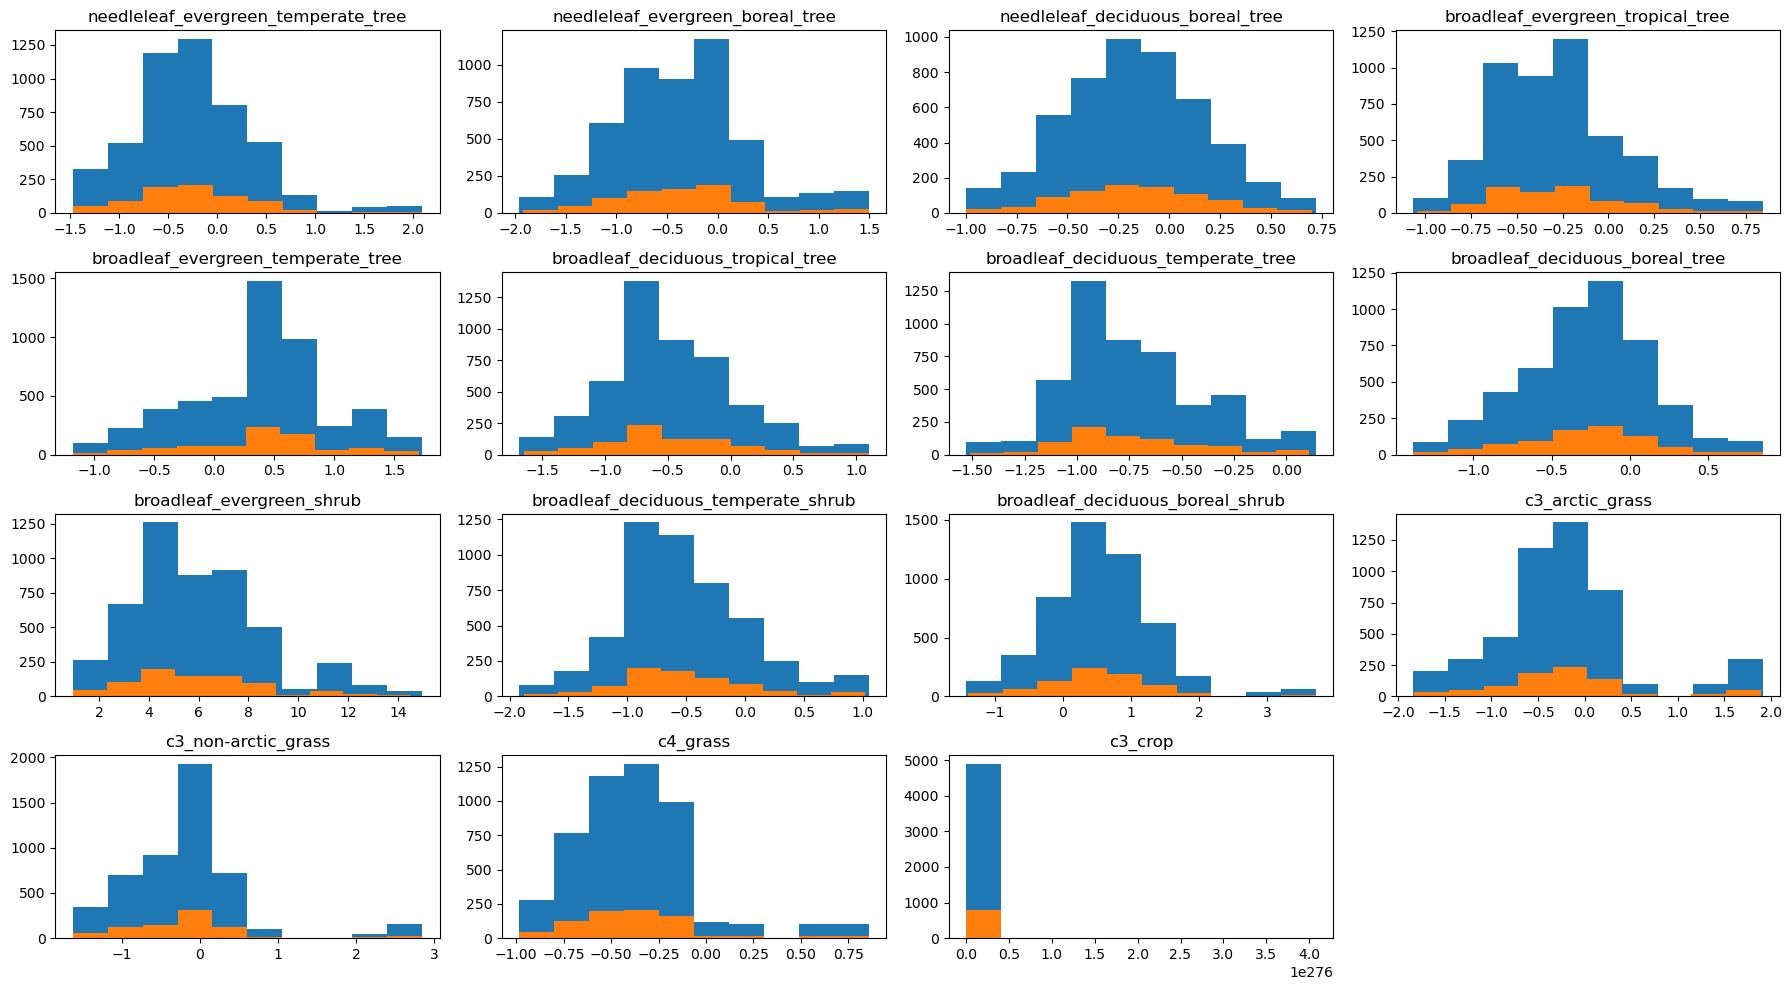

In [132]:
plt.figure(figsize=[18,10])
for i in range(1,16):
    plt.subplot(4,4,i)
    plt.hist(fbias_fine[i,:])
    plt.hist(fbias_usets_filtered[i,:,:].flatten())
    plt.title(pfts[i],fontsize=12)
plt.tight_layout()
plt.savefig('./figs/finetune_dist_filteredsets.png')

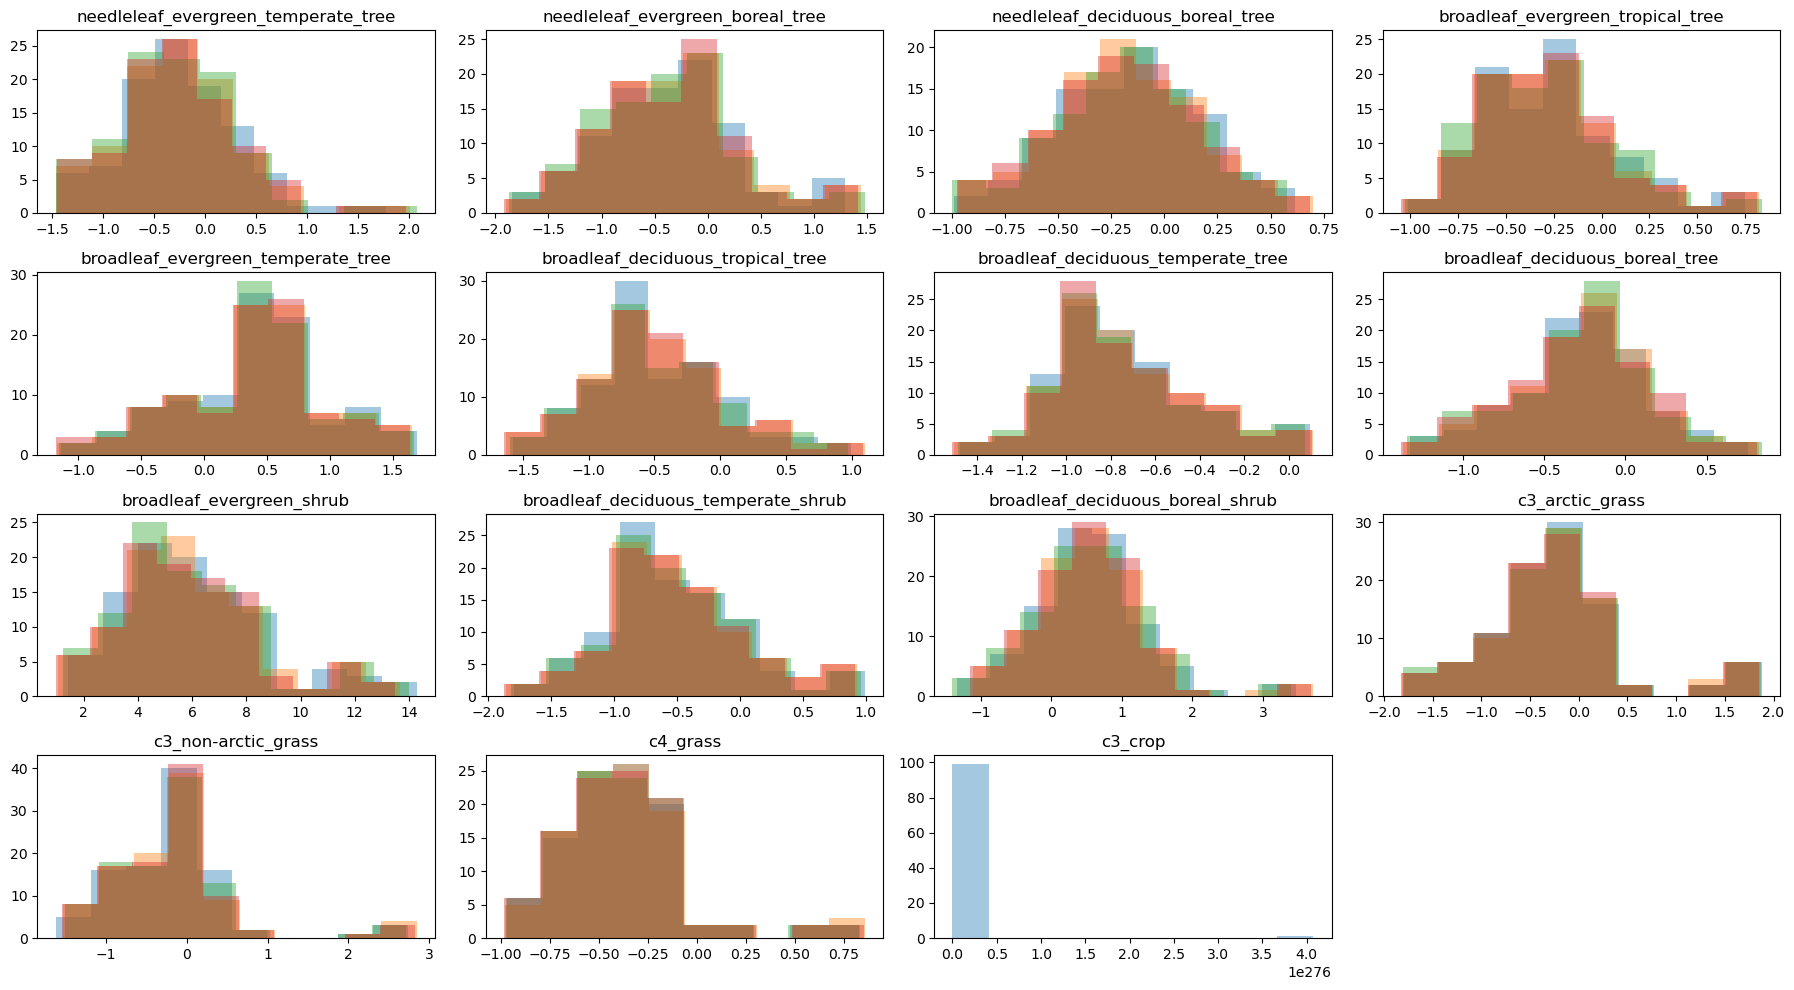

In [126]:
plt.figure(figsize=[18,10])
for i in range(1,16):
    plt.subplot(4,4,i)
    #plt.hist(fbias_fine[i,:])
    plt.hist(fbias_usets_filtered[i,:,1].flatten(),alpha = 0.4)
    plt.hist(fbias_usets_filtered[i,:,2].flatten(),alpha = 0.4)
    plt.hist(fbias_usets_filtered[i,:,3].flatten(),alpha = 0.4)
    plt.hist(fbias_usets_filtered[i,:,4].flatten(),alpha = 0.4)
    plt.title(pfts[i],fontsize=12)
plt.tight_layout()


In [136]:
np.shape(fbias_usets_filtered)

(16, 100, 8)

In [157]:
# Find SLATOP values the minimize error for each PFT
pvals = np.empty((16,len(fine_usets)))
for p in np.arange(1,16):
    tmp = np.argmin(np.abs(fbias_usets_filtered[p,:,:]),axis=0)
    pvals[p,:] = uniform_sample[tmp]
# then select the PFT specific value of slatop that best matches laisp
#pft1_minid = np.argmin(np.abs(fbias_fine[1,:]))
#fine_sample.iloc[pft1_minid,:]

In [204]:
leafCN = Usets.iloc[fine_usets_ids]['leafcn']
leaf_long = Usets.iloc[fine_usets_ids]['leaf_long']
jmax = Usets.iloc[fine_usets_ids]['jmaxb0']
kmax = Usets.iloc[fine_usets_ids]['kmax']

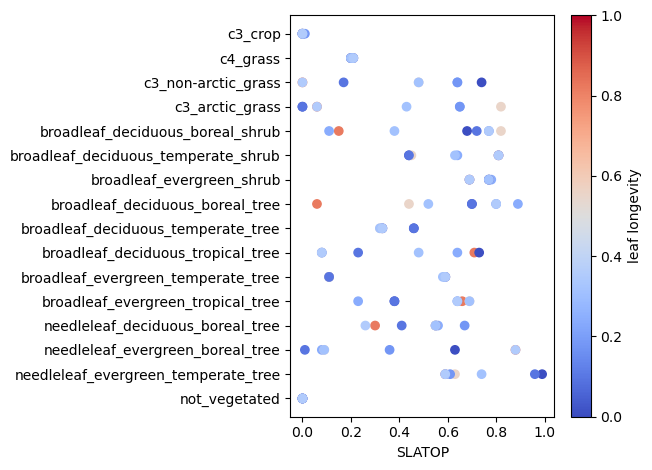

In [205]:
x = np.reshape(np.repeat(np.arange(0,16),8),(16,8))
for i in range(16):
    plt.scatter(pvals[i,:],x[i,:],c=kmax,cmap='coolwarm',vmin=0,vmax=1)
#plt.ylabel(pfts,rotation=0)
plt.yticks(ticks=range(16), labels=pfts[0:16])
plt.xlabel('SLATOP')
plt.colorbar(label='leaf longevity')
plt.tight_layout()
#plt.savefig('./figs/finetune_slatop_byPFT_leaflong.png')

### Check emulator performance against EmBE experiment CLM runs

In [4]:
NETT_emulator = tf.saved_model.load('//glade/work/linnia/CLM-PPE-LAI_tests/exp2_PFT/models/needleleaf_evergreen_temperate_tree/')
#result = NETT_emulator.predict(test_sample)

2023-07-26 12:52:59.481055: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-26 12:52:59.481112: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc62): /proc/driver/nvidia/version does not exist
2023-07-26 12:52:59.483270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# load LHC LAI
ds_new_h1=get_exp('EmBE',dvs=['TLAI'],tape='h1',yy=(2003,2014))

t=slice(str(2003),str(2014))
e = slice(1,49)
ds_new = ds_new_h1.TLAI.sel(time=t,ens=e)

In [6]:
la=xr.open_dataset('landarea_transient.nc').landarea_pft.sel(time=t)
amax_lai_EmBE=amax(ds_new).mean(dim='year').compute()
PPE_lai_EmBE = pmean(amax_lai_EmBE,la).mean(dim='time').compute()
# OLD: PFT_EmBE = amax(pmean(ds_new,la)).mean(dim='year').compute()

In [7]:
# load parameter sets 
lhckey = '../exp1_EmBE/psets_exp1_EmBE_230419.txt'
df = pd.read_csv(lhckey)
ppe_params_new = df.drop(columns='member')

In [10]:
ppe_params_embe = pd.concat([ppe_params_new[u_params], ppe_params_new[pft_params]],axis=1)

In [22]:
y_pred, y_pred_var =NETT_emulator.predict(np.array(ppe_params_embe.values))

ValueError: Python inputs incompatible with input_signature:
  inputs: (
    [[6.06832542e-04 7.59488220e-01 8.90391501e-01 ... 1.25318343e-01
  9.17931957e-01 8.93507323e-01]
 [7.28388488e-01 2.99565258e-01 1.07862786e-01 ... 8.89825937e-01
  5.15505684e-01 7.33553532e-01]
 [4.92496570e-01 1.76597886e-01 5.59738240e-01 ... 3.03110618e-01
  9.72542529e-01 4.51420423e-01]
 ...
 [9.39623421e-02 2.35586462e-01 3.34228360e-01 ... 9.34068369e-01
  7.37880809e-01 8.58692219e-01]
 [8.38360604e-01 9.62164594e-01 8.86653919e-01 ... 7.65087780e-01
  6.40324461e-01 6.31060168e-01]
 [2.02566395e-01 1.14956982e-01 4.40821630e-01 ... 4.67561087e-01
  8.10490979e-01 6.64947191e-01]])
  input_signature: (
    TensorSpec(shape=(None, 30), dtype=tf.float64, name=None)).

In [13]:
## Use PFT emulators to predict samples 
EmBE_pred = np.empty([16,len(ppe_params_embe)])
EmBE_pred_var = np.empty([16,len(ppe_params_embe)])

for i,p in enumerate(pfts[1:16]):
    y_pred, y_pred_var = PFT_emulator_dict[p].predict_f(ppe_params_embe.values)
    EmBE_pred[i] = unstandardize(np.array(y_pred).reshape(1,-1),PPE_lai.sel(pft=i+1))
    EmBE_pred_var[i] = unstandardize(np.array(y_pred_var).reshape(1,-1),PPE_lai.sel(pft=i+1))

NameError: name 'PFT_emulator_dict' is not defined

In [ ]:
plt.scatter(

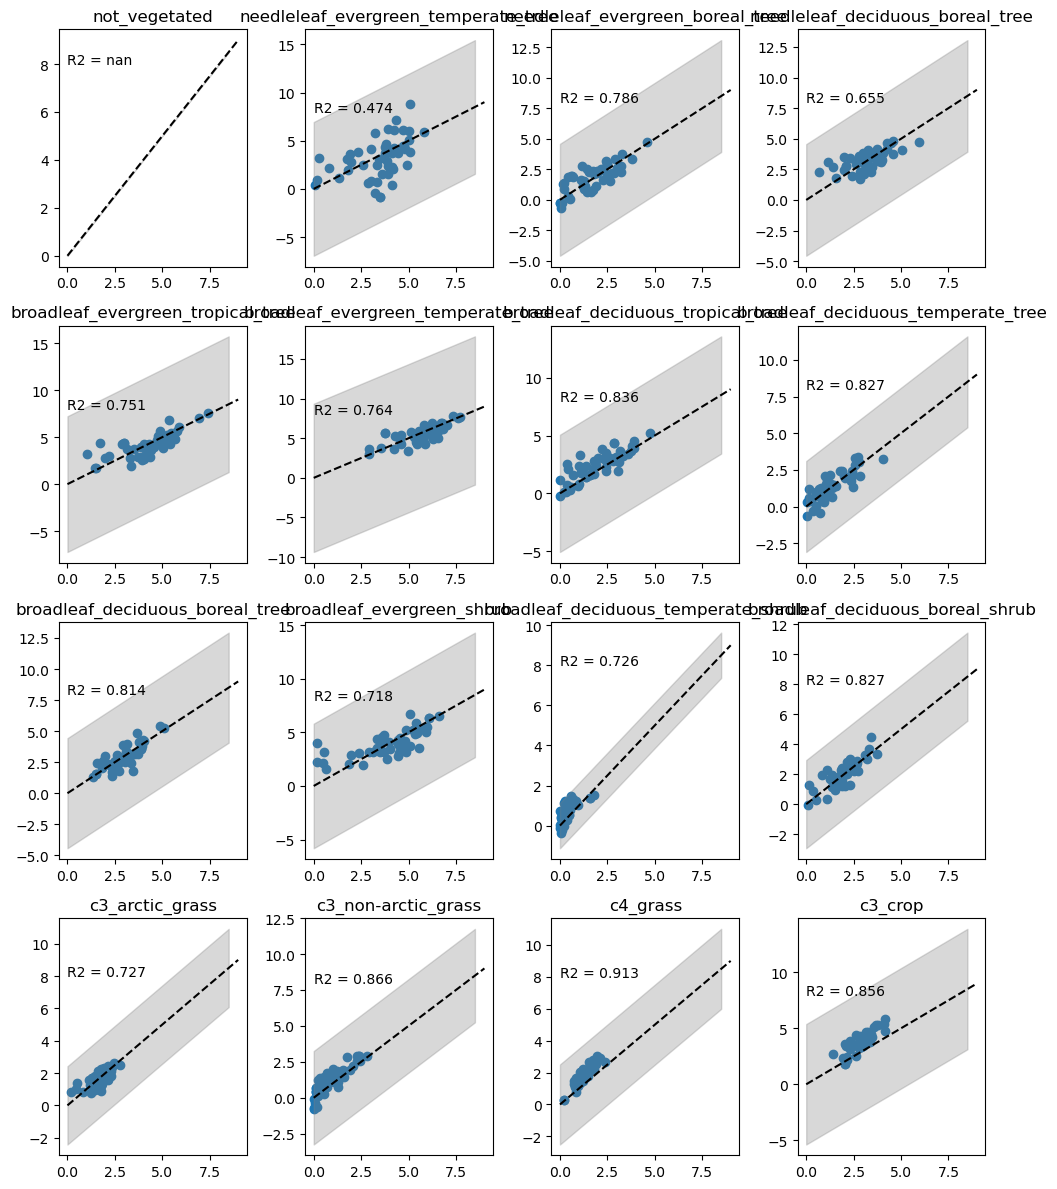

In [66]:
plt.figure(figsize=[10,12])
plt.rcParams.update({'font.size': 10})

for i,p in enumerate(pfts[1:17]):
    ax = plt.subplot(4,4,i+1)
    r2 = np.corrcoef(PFT_EmBE[i,:],EmBE_pred[i-1,:])
    ax.scatter(PFT_EmBE[i,:],EmBE_pred[i-1,:])
    ax.plot([0,9],[0,9],linestyle='--',color='k')
    y = np.arange(0,9,0.5)
    ax.fill_between(y,y-EmBE_pred_var[i-1,0],y+EmBE_pred_var[i-1,0],color='grey',alpha=0.3)
    ax.text(0,8,'R2 = '+str(np.round(r2[0,1],3)),fontsize=10)
    ax.set_title(pfts[i])
    
plt.tight_layout()
plt.savefig('./figs/PFT_LAImax_emulator_validation_EmBE_GPFlow.png')

### Sample from priors

In [3]:
import scipy.stats as st
#parameter values from passing psets: (hypothetical)
shape, scale = 2., 1. # mean and width
s = np.random.standard_gamma(shape,1000)
#fit KDE to parameter values
kde = st.gaussian_kde(s)
# take random draws from KDE
samp = kde.resample(1000)

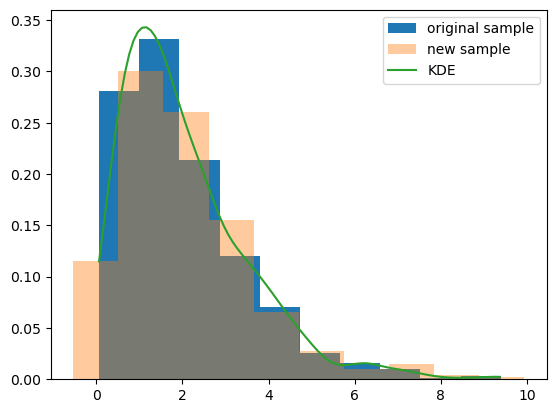

In [33]:
# Does it match?
x = np.arange(min(s),max(s),0.1)
out = kde(x)
plt.hist(s,density=True,label='original sample')
plt.hist(samp.flatten(),density=True,alpha=0.4,label='new sample')
plt.plot(x,out,label='KDE')
plt.legend()

### Misc

In [ ]:
# take the cartesian product of uniform sample for pft_params
uniform_sample = np.arange(0,1.0,0.1)
#arrays = np.vstack((uni_sample,uni_sample,uni_sample,uni_sample,uni_sample,uni_sample,uni_sample,uni_sample,uni_sample,uni_sample,uni_sample))
arrays = np.vstack(uniform_sample)
pft_sample = cartesian(arrays)